In [1]:
from IPython.display import display
from IPython.display import Image
from IPython.display import HTML
import os
from utils import * # Code shared across more than one notebook

SAVE_DATA = True
GENERATE_NEW_DATA_ALWAYS = False
DO_K3D_PLOT = True

# gVirtualXRay CT acquisition vs chest phantom CT data

**Outline:**
This notebook demonstrates the use of gVirtualXRay in a CT medical application. For this experiment, we attempt to recreate a real CT acquisition of the [Lungman chest phantom](https://www.kyotokagaku.com/en/products_data/ph-1_01/) with gVirtualXRay. 

1. The CT of a chest phantom has been generated from a real scanner ahead of time. 
2. Structures in the reference CT have been segmented and labelled. 
3. The resultant surfaces from the segmentations form a virtual lungman model. 
4. We use gVirtualXRay to simulate CT acquisition on this model and 
5. compare the result with the reference CT. 

An advantage of some experiments in this notebook is that a significant number of samples ($512 \times 512 \times 426$) are used in comparisons. A concern is that the quality of the virtual chest phantom, used as the gVirtualXRay sample, is solely dependent on manual segmentation giving additional error to X-Ray data outside of gVirtualXRay's responsibility.  

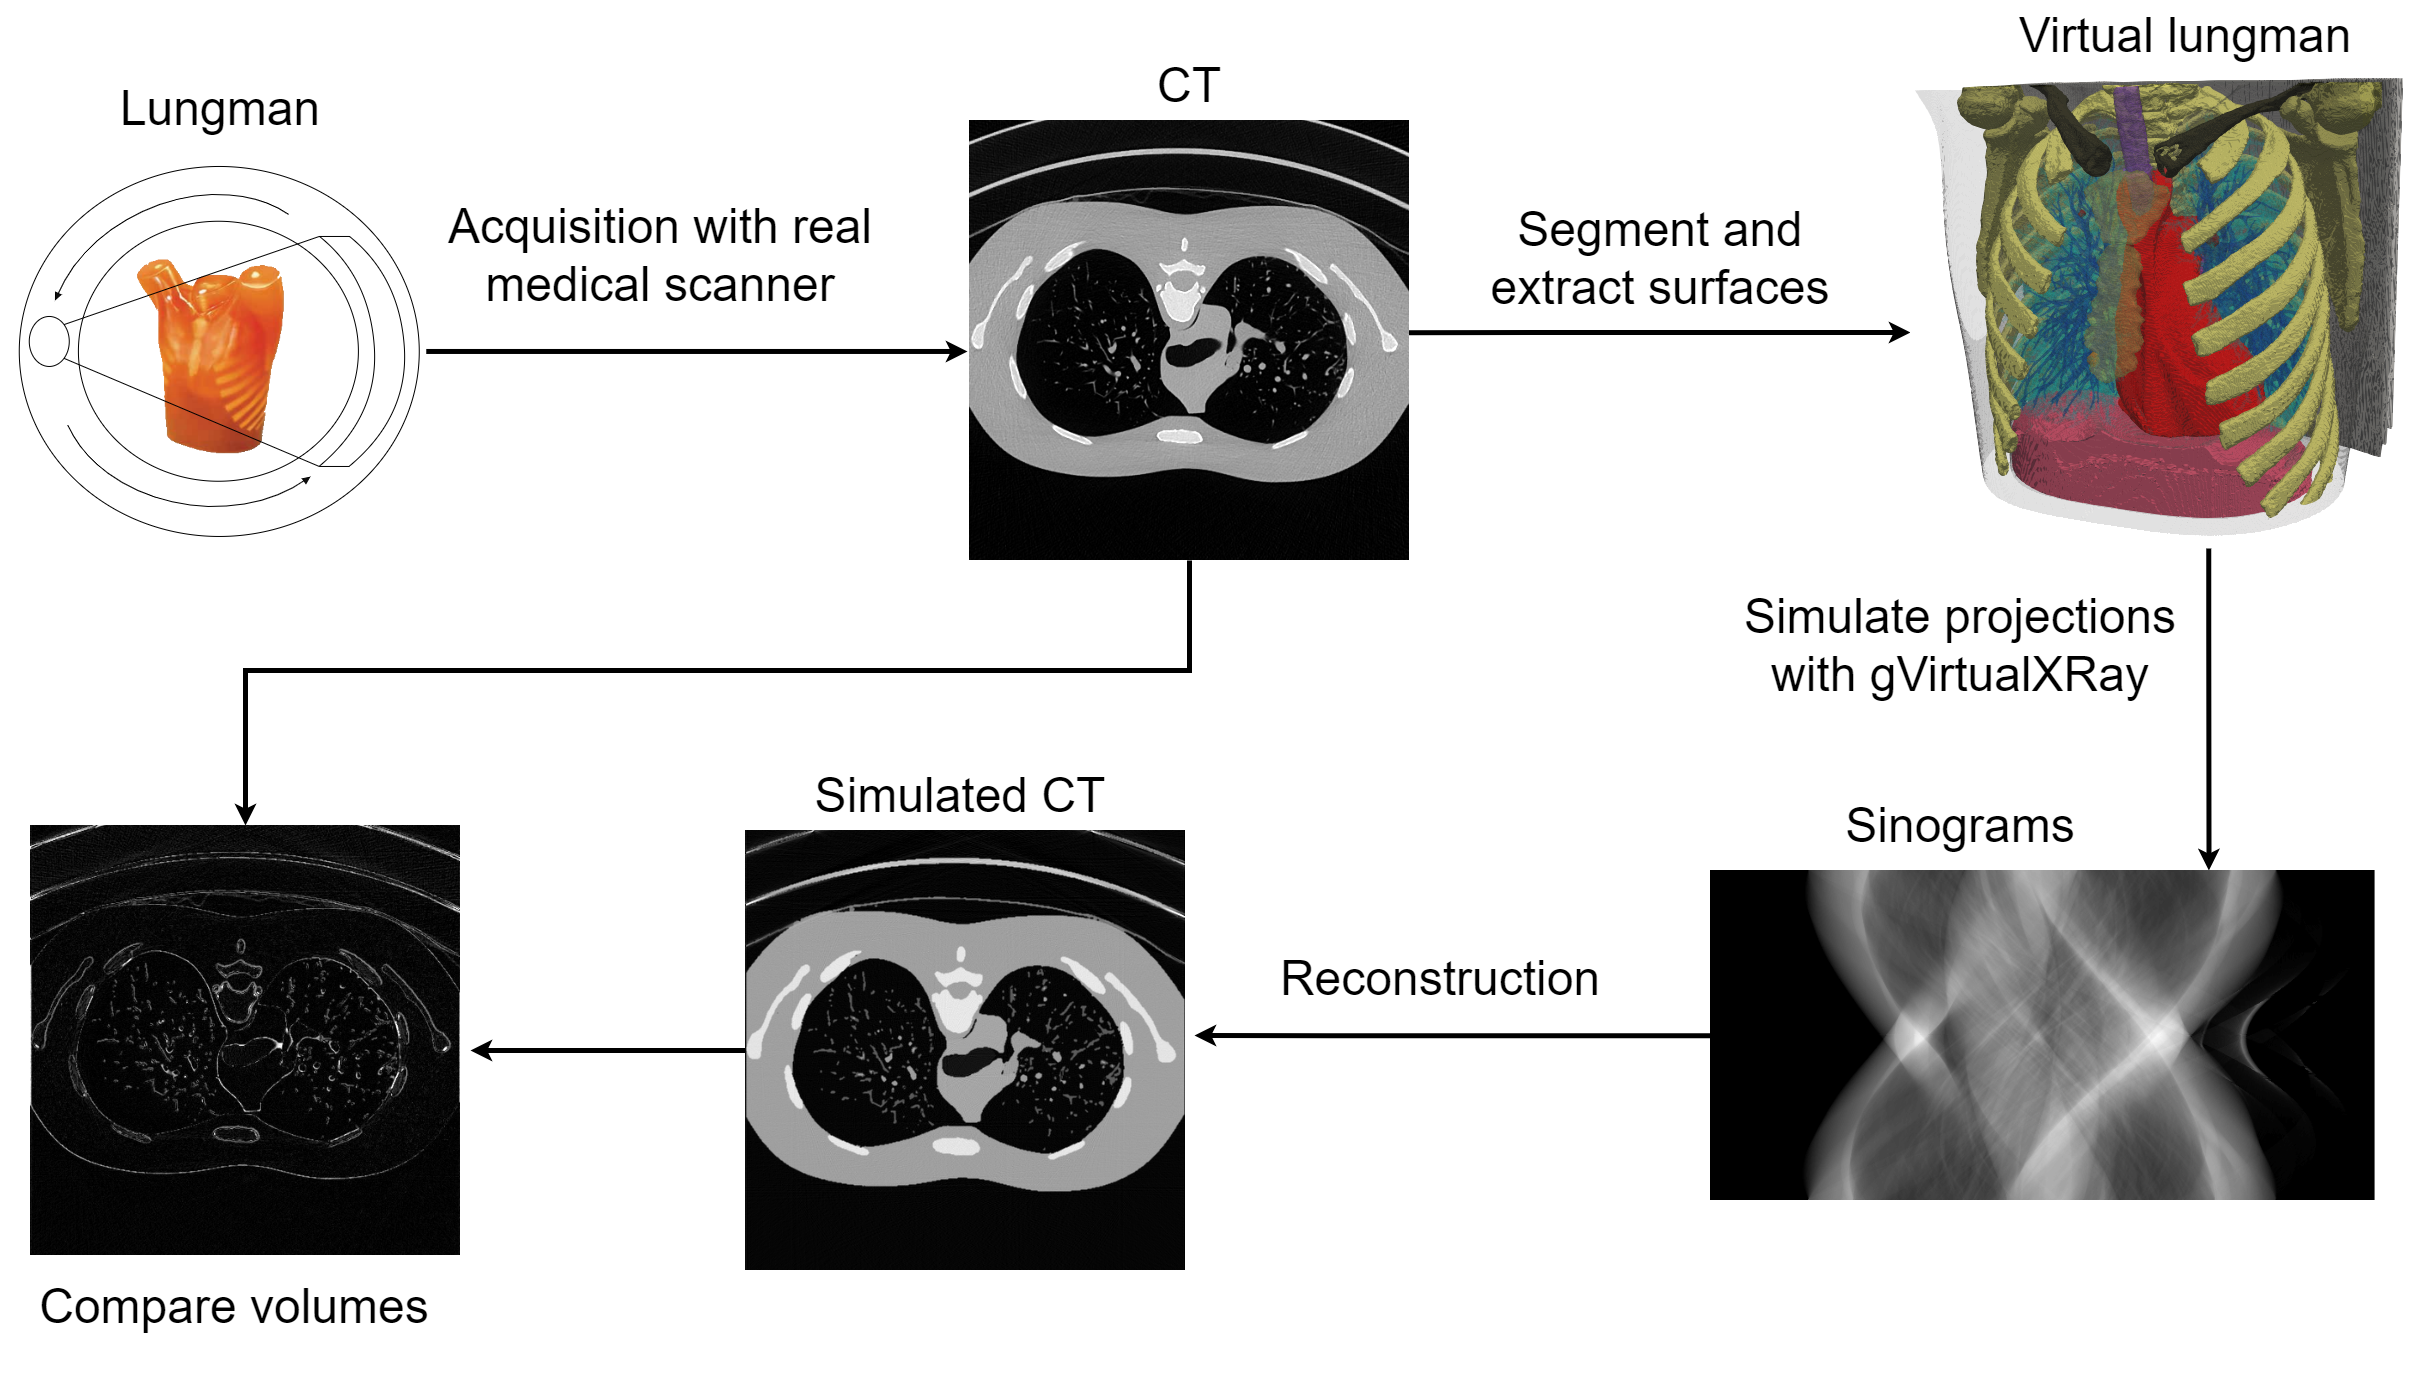

In [2]:
Image("../doc/gvxrflow.drawio.png", width=800)

**Methods and materials:** The setup for gVirtualXRay involved a sample centered about the origin, placing the source 500mm away from the object (SOD) and the detector also 500mm away (SDD). \
The beam is monochromatic with photons having 72keV of energy. A parallel beam is used in this experiment for simplicity because recovering the parameters from the original acquisition with the medical scanner would be difficult. \
The detector is set-up to best match the reference CT accounting for pixel size, resulting in the detector being approximately 453mm wide and 298mm tall. A width of 725 ($512 \times \sqrt{2}$) pixels is used instead of the 512 pixels found in the reference CT so the inscribed circle can be removed during the reconstruction process.

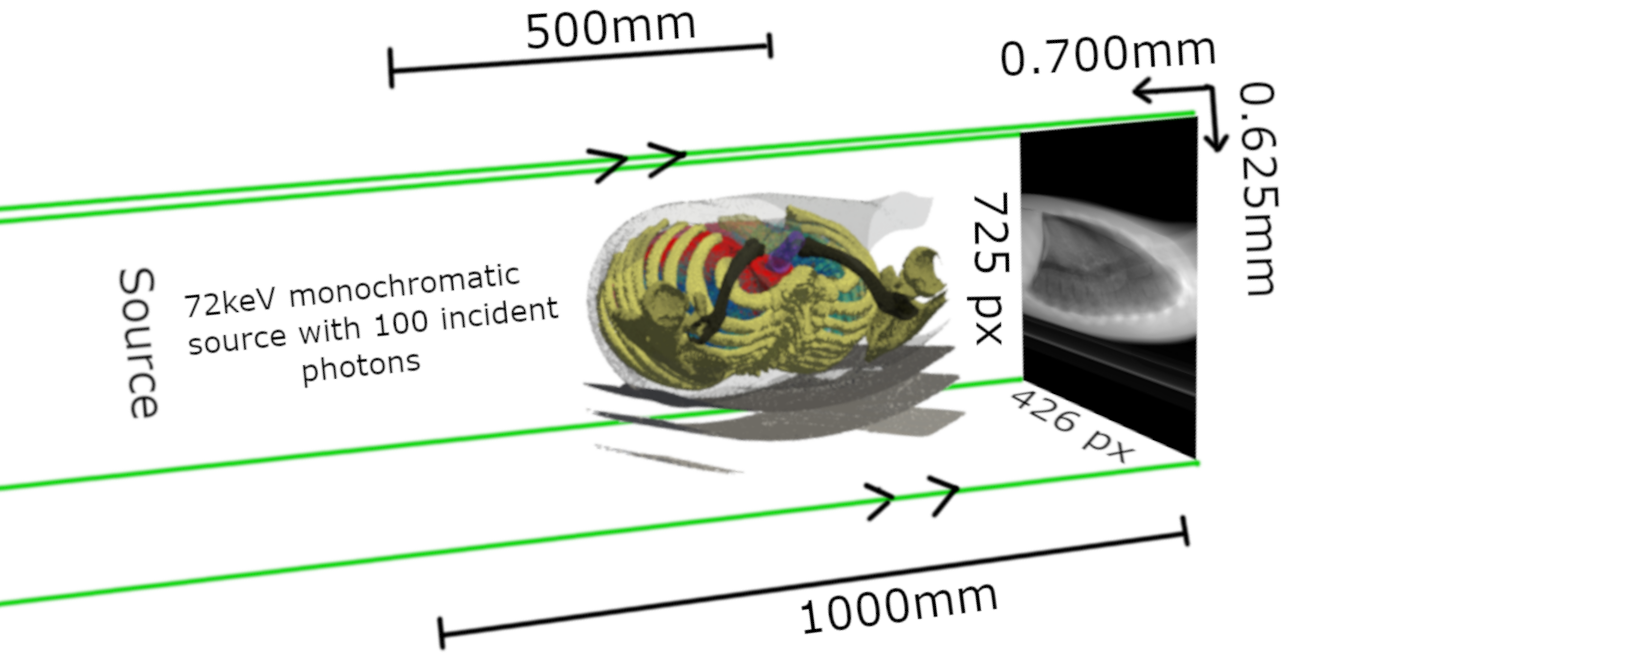

In [3]:
Image("../doc/gvxr-lungman-environment.png", width=800)

In [4]:
#with open('../doc/chest-paraview.gif','rb') as f:
#   display(Image(data=f.read(), format='png', width=480))

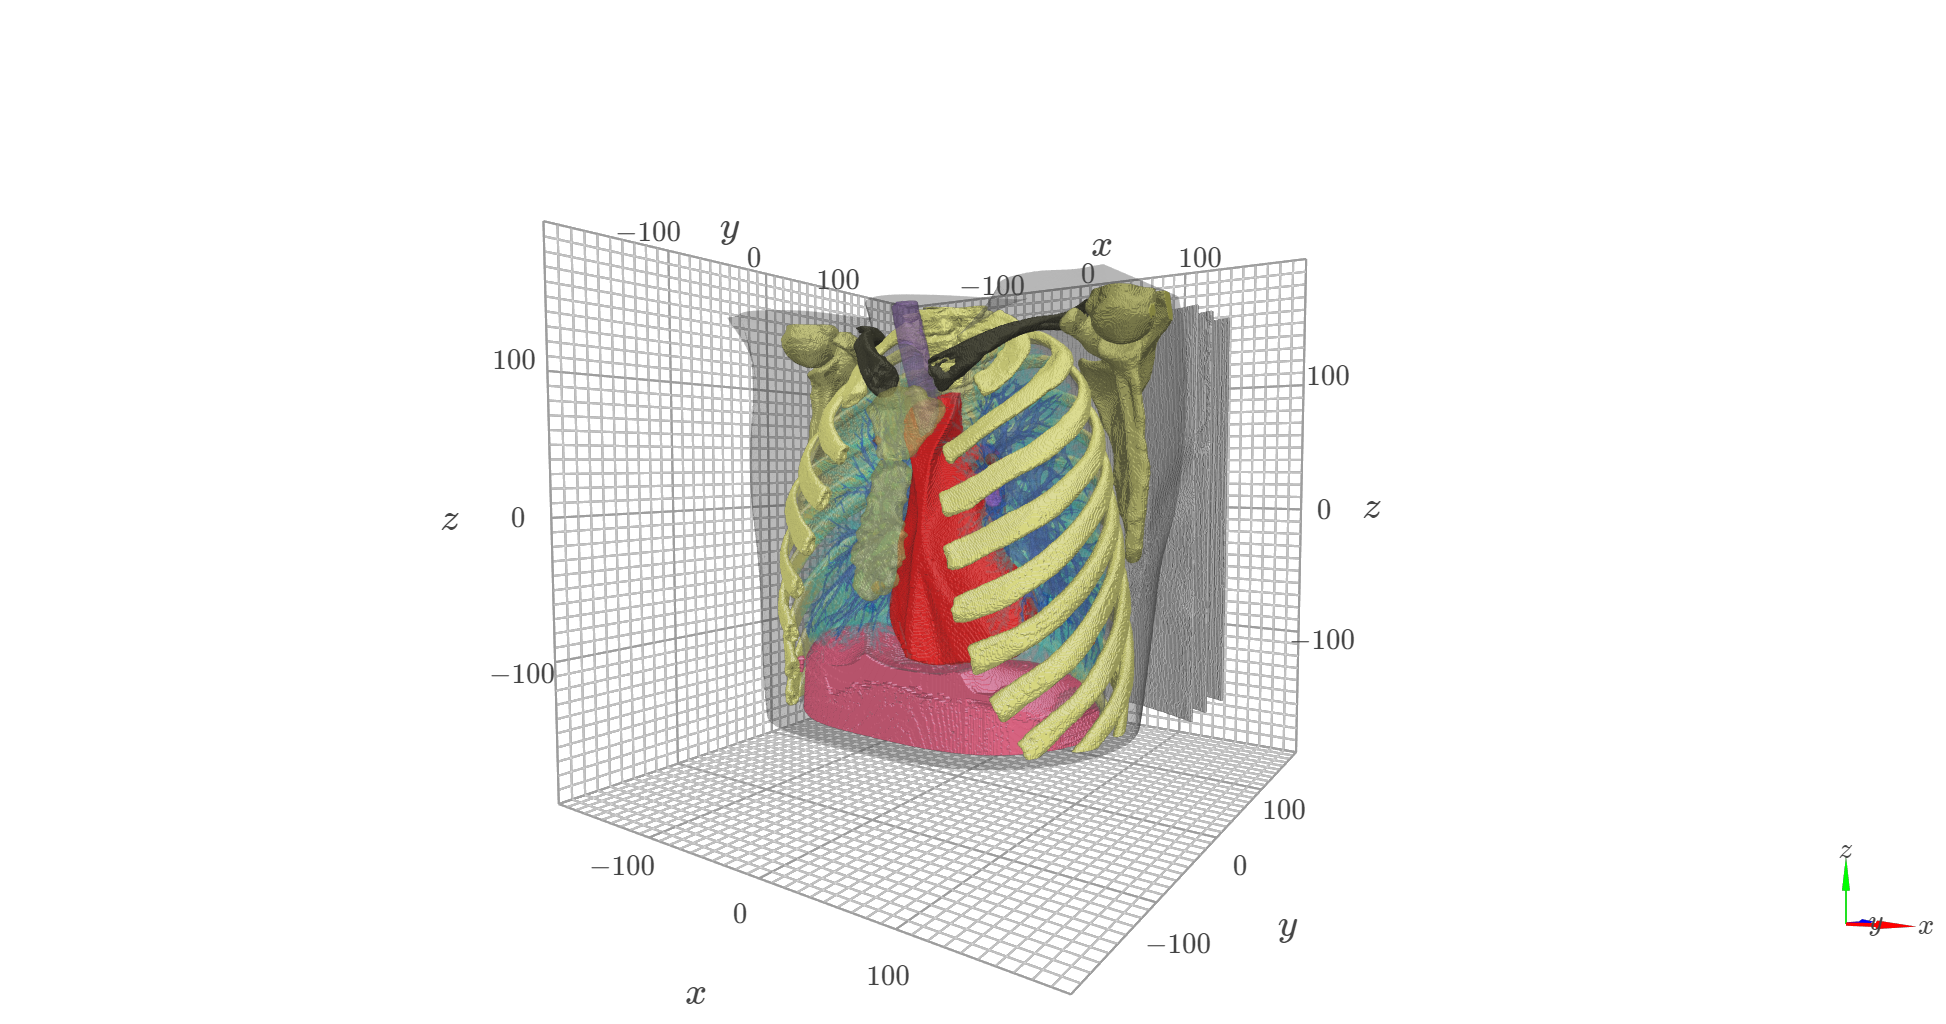

In [53]:
fname = "./plots/lungman_model.png"
if os.path.exists(fname):
    display(Image(fname))

# Results

**Diagonal plot comparison**\
These two plots are sampled from the diagonal pixels of slice 150 from both the ground truth CT and simulated CT of the chest phantom.\
<span style="color:green">Green</span>: Ground truth CT plot\
<span style="color:red">Red</span>: Simulated CT plot\
This experiment proves the most significant changes in attenuation are accurately simulated. The simulated CT appears less noisy presumably because our experiment does not account for the natural deviation of image quality that comes with real equipment.

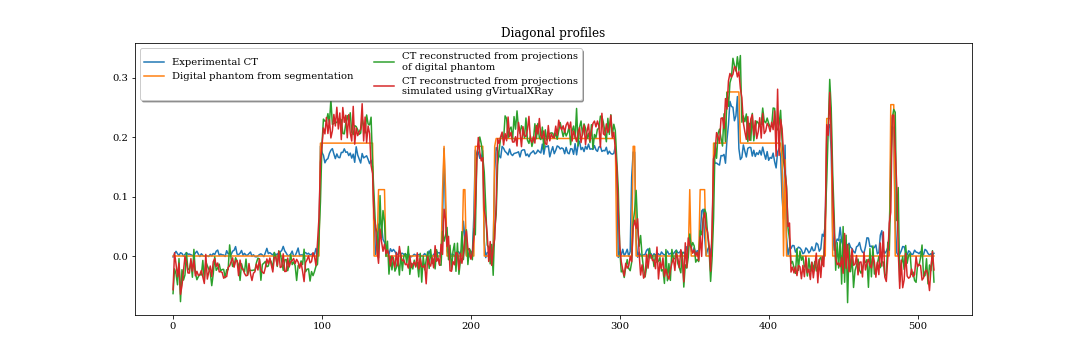

In [6]:
fname = "plots/lungman-profiles-CT-mu.png"
if os.path.exists(fname):
    display(Image(fname))

**Quantitative comparisons**\
From qauntative measures we achieved: a ZNCC score of 0.977 (97.7% similarity), a MAPE/MAPD 0.293 and a SSIM score of 0.911. For reference, a good ZNCC and SSIM score is 1 and a good MAPE score is 0.

The calculations were performed on the following platform:

In [7]:
printSystemInfo()

OS:
	Windows 10
	AMD64

CPU:
 	AMD Ryzen 5 5600X 6-Core Processor

RAM:
	16 GB
GPU:
	Name: NVIDIA GeForce GTX 970
	Drivers: 496.49
	Video memory: 4 GB


# Import packages

In [8]:
tomography_backend = "scikit-image"
tomography_backend = "tigre"
tomography_backend = "tomopy"

In [9]:
%matplotlib inline

import SimpleITK as sitk
import pandas as pd
import numpy as np
import numpy.ma as ma # Masking
from utils import *
from convertRaw import *
import gvxrPython3 as gvxr
import json2gvxr

import matplotlib
import matplotlib.pyplot as plt

font = {'family' : 'serif'#,
        #'weight' : 'bold',
         # 'size'   : 22
       }
matplotlib.rc('font', **font)
# matplotlib.rc('text', usetex=True)

from tifffile import imread, imwrite # Load/Write TIFF file

if tomography_backend == "tomopy":
    import tomopy
elif tomography_backend == "tigre":
    import tigre
    import tigre.algorithms as algs
    import tomopy
elif tomography_backend == "scikit-image":
    from skimage.transform import iradon
    from skimage.transform import radon
else:
    IOError("No tomography reconstruction backend")

from sitk2vtk import *
from sklearn.metrics import mean_absolute_percentage_error as mape
from skimage.metrics import structural_similarity as ssim
import skimage

#import scipy
import os
import math
import zipfile
import datetime

import imageio

import k3d
import random
import base64
from stl import mesh
from time import sleep

SimpleGVXR 1.0.1 (2021-12-06T23:05:25) [Compiler: Microsoft Visual Studio] on Windows
gVirtualXRay core library (gvxr) 1.1.5 (2021-12-06T23:05:24) [Compiler: Microsoft Visual Studio] on Windows


# Performance
* The number of threads chosen will largely dictate the speed of reconstruction.
* The number of projections will affect the quality of the reconstruction.
* Artefact filtering, as you can expect, provides better quality image at the expense of speed.
* Artefact filtering on the GPU gives a decent compromise of speed to quality.

In [10]:
ray_energy = 72
DO_ARTEFACT_FILTERING_ON_GPU = True
DO_ARTEFACT_FILTERING_ON_CPU = False

number_of_projections = 180
span = 180
angular_step = span / number_of_projections;
theta_deg = np.linspace(0.0, angular_step * number_of_projections, num=number_of_projections, endpoint=False)

In [11]:
print("Number of projections:", theta_deg.shape[0])
print("Angle between successive projections:", angular_step)
print("First angle:", theta_deg[0])
print("Last angle:", theta_deg[-1])

Number of projections: 180
Angle between successive projections: 1.0
First angle: 0.0
Last angle: 179.0


In [12]:
print(theta_deg)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179.]


# Configure gVirtualXRay environment
**Create an OpenGL context and window.**

In [13]:
json2gvxr.initGVXR("notebook-11.json", "OPENGL");

Create an OpenGL context: 512x512


**Create a parallel photon beam.**

In [14]:
json2gvxr.initSourceGeometry();
gvxr.setMonoChromatic(ray_energy, "keV", 100);
gvxr.useParallelBeam();

Set up the beam
	Source position: [0, -500, 0, 'mm']
	Source shape: ParallelBeam


**Create a detector array.**

In [15]:
json2gvxr.initDetector("notebook-11.json");

Set up the detector
	Detector position: [0, 500, 0, 'mm']
	Detector up vector: [0, 0, 1]
	Detector number of pixels: [725, 426]
	Pixel spacing: [0.625, 0.7, 'mm']


In [16]:
nb_pixels = gvxr.getDetectorNumberOfPixels()
detector_size = gvxr.getDetectorSize("mm")
pixel_width = detector_size[0] / nb_pixels[0]
pixel_height = detector_size[1] / nb_pixels[1]

## Load the ground truth

In [17]:
# Read the reference CT
sitk_reader = sitk.ImageFileReader();
sitk_reader.SetImageIO("MetaImageIO");
sitk_reader.SetFileName("lungman_data/lungman.mha")
raw_ground_truth = sitk_reader.Execute()
real_CT_in_HU = np.array(sitk.GetArrayFromImage(raw_ground_truth));

#
# Blur using CurvatureFlowImageFilter
#
# blurFilter = sitk.CurvatureFlowImageFilter()
# blurFilter.SetNumberOfIterations(5)
# blurFilter.SetTimeStep(0.125)
# sitk_ground_truth_CT_recons_in_HU = blurFilter.Execute(raw_ground_truth)
# ground_truth_CT_recons_in_HU = np.array(sitk.GetArrayFromImage(sitk_ground_truth_CT_recons_in_HU));

# Make sure each volume has floating point precision
real_CT_in_HU = real_CT_in_HU.astype(np.single);

# Drop the first and last slices
# ground_truth_CT_recons_in_HU = ground_truth_CT_recons_in_HU[1:ground_truth_CT_recons_in_HU.shape[0] - 1]

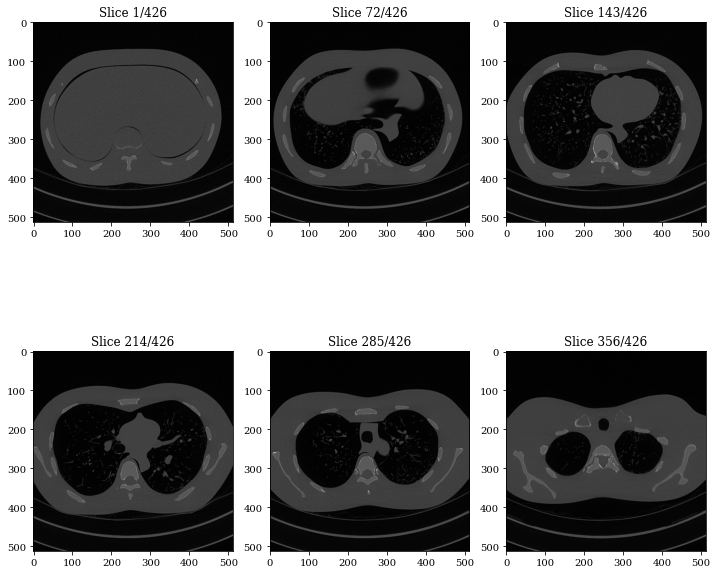

In [18]:
ncols = 3
nrows = 2

step = int(real_CT_in_HU.shape[0] / (ncols * nrows))
slices = range(0, int(real_CT_in_HU.shape[0]), step)

fig = plt.figure(figsize= (10,10))

ct_min_val = real_CT_in_HU.min()
ct_max_val = real_CT_in_HU.max()

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Slice " + str(slice_id + 1) + "/" + str(real_CT_in_HU.shape[0]))
        ax.imshow(real_CT_in_HU[slice_id], cmap='gray', vmin=ct_min_val, vmax=ct_max_val)
        
plt.tight_layout()

plt.savefig('plots/lungman-real_CT_in_HU.pdf')
plt.savefig('plots/lungman-real_CT_in_HU.png')

In [19]:
def ShouldGenerateNew(*fnames):
    if (GENERATE_NEW_DATA_ALWAYS): return False;
    for fname in fnames:
        if (not os.path.exists(fname)): return True
        
    return False

# Convert ground truth from HU to &mu;

In [20]:
fname = "gVirtualXRay_output_data/lungman-real_CT_in_mu.mha"

if ShouldGenerateNew(fname):

    #real_CT_in_mu = np.array(gvxr.convertHU2mu(real_CT_in_HU, ray_energy, "keV"))
    mu_air  =gvxr.getMuFromHU(-1000.0, 72, "keV");
    mu_water  =gvxr.getMuFromHU(0.0, 72, "keV");
    real_CT_in_HU = real_CT_in_HU.astype(np.double);
    real_CT_in_mu = ((real_CT_in_HU / 1000.0 ) * (mu_water - mu_air)) + mu_water;
  
   
    if SAVE_DATA:
      
        sitk_real_CT_in_mu = sitk.GetImageFromArray(real_CT_in_mu)
        sitk_real_CT_in_mu.SetSpacing([pixel_width, pixel_width, pixel_height])

        sitk_real_CT_in_mu.SetOrigin((-pixel_width * real_CT_in_mu.shape[2] / 2.0,
                              -pixel_width * real_CT_in_mu.shape[1] / 2.0,
                              -pixel_height * real_CT_in_mu.shape[0] / 2.0))
    
        sitk.WriteImage(sitk_real_CT_in_mu, fname, useCompression=True)

else:
    sitk_real_CT_in_mu = sitk.ReadImage(fname)
    real_CT_in_mu = sitk.GetArrayFromImage(sitk_real_CT_in_mu)

# Extract data for this experiment
The labelled volumes are provided compressed in a zip file. Use this procedure to extract the surfaces and masks needed for this notebook.

In [21]:
# Uncompress the labels
if (False == os.path.isfile("./lungman_data/segmentation-uncompressed/labels.mha")):
    with zipfile.ZipFile(  "./lungman_data/segmentation-compressed.zip", 'r') as myzip:
        myzip.extractall(  "./lungman_data/segmentation-uncompressed")

# Read the records for isovalue, average HU
mapHandle = open("./lungman_data/segmentation-uncompressed/map.dat");
bytes = mapHandle.read();
split_lines = bytes.split('\n');
bytes = None;
mapHandle.close();

# Read labels
label_rel_path = "./lungman_data/segmentation-uncompressed/labels.mha";
phantom = sitk.ReadImage(label_rel_path)
phantom_array = sitk.GetArrayFromImage(phantom)

In [22]:
# rd = vtk.vtkMetaImageReader();
# rd.SetFileName(label_rel_path);
# rd.Update()
# vtkLabels = rd.GetOutput();

# Create threshold filter
# threshold = vtk.vtkImageThreshold();
# threshold.SetInputData(vtkLabels);
# threshold.SetReplaceOut(0);
# threshold.ReplaceOutOn()
# threshold.ReplaceInOff();

fname_HU = "gVirtualXRay_output_data/lungman-ground_truth2-CT-in_HU.mha"
fname_mu = "gVirtualXRay_output_data/lungman-ground_truth2-CT-in_mu.mha"

ref_data = {}

if ShouldGenerateNew(fname_HU, fname_mu):
    digital_phatom_in_HU = np.zeros(phantom_array.shape, dtype=np.int16) - 1000
    digital_phatom_in_mu = np.zeros(phantom_array.shape, dtype=np.single)
else:
    sitk_digital_phatom_in_HU = sitk.ReadImage(fname_HU)
    digital_phatom_in_HU = sitk.GetArrayFromImage(sitk_digital_phatom_in_HU)

    sitk_digital_phatom_in_mu = sitk.ReadImage(fname_mu)
    digital_phatom_in_mu = sitk.GetArrayFromImage(sitk_digital_phatom_in_mu)    
    
for i in range(0, len(split_lines)):
    
    tuple_parts = split_lines[i].split('\t');
    
    structure_name = tuple_parts[2][0:-4]
    structure_isovalue = int(tuple_parts[0])

    print("Process", structure_name)
    
    # See if the surface already exists
    stl_rel_path = "./lungman_data/meshes/" + tuple_parts[2][0:-4] + ".stl";
    # if (True == os.path.isfile(stl_rel_path)): continue;
    
    # Threshold to get label
#     threshold.ThresholdBetween(structure_isovalue, structure_isovalue);
#     threshold.Update();
#     vtkIm = threshold.GetOutput();
    
#     # Extract surface and save
#     vtkSurface = extractSurface(vtkIm, structure_isovalue);
#     writeSTL(vtkSurface, stl_rel_path);
#     vtkSurface = None;
#     vtkIm = None;    

    # Threshold the phantom
    binary_mask = (phantom == structure_isovalue)
    
    # Pad the image
    filt = sitk.ConstantPadImageFilter()
    filt.SetConstant (0)
    filt.SetPadLowerBound ([1, 1, 1])
    filt.SetPadUpperBound ([1, 1, 1])
    binary_image = filt.Execute(binary_mask)               

    # Create a VTK image
    binary_array = sitk.GetArrayFromImage(binary_image)
    vtkimg = sitk2vtk(binary_image, centre=True)

    # binary_array = sitk.GetArrayFromImage(binary_image)
    min_val = binary_array.min()
    max_val = binary_array.max()

    threshold = min_val + 0.5 * (max_val - min_val)

    vtkmesh = extractSurface(vtkimg, threshold)
    del vtkimg

    writeSTL(vtkmesh, stl_rel_path)
    del vtkmesh
    
    
    # Get HU/mu

    if ShouldGenerateNew(fname_HU, fname_mu):

        kernel_radius = 2;

        # Sheets are too slim to be eroded so much
        if (structure_name.find("sheet") != -1):
            kernel_radius = 1;

        # Erode the mask
        erode = sitk.BinaryErodeImageFilter();
        erode.SetKernelRadius(kernel_radius);
        erode.SetForegroundValue(1);
        sitk_eroded_mask = erode.Execute(binary_mask);
        del erode

        eroded_mask = np.array(sitk.GetArrayFromImage(sitk_eroded_mask));
        del sitk_eroded_mask

        # Apply mask to simulated CT
        erored_test = (eroded_mask == 1)
        
        test = phantom_array == structure_isovalue
        avg_HU = np.mean(real_CT_in_HU[erored_test])
        avg_mu = np.mean(real_CT_in_mu[erored_test])

        # print("\t\t\"Material\": [\"HU\",", avg_HU, "]")
                
        ref_data[structure_name] = [avg_HU, avg_mu]
        digital_phatom_in_HU[test] = round(avg_HU)
        digital_phatom_in_mu[test] = avg_mu

Process bronchioles
Process bronchus
Process trachea
Process diaphram
Process skin
Process heart
Process ribs_spine
Process scapulas
Process sternum
Process clavicle
Process sheets_low
Process sheets_med
Process sheets_high
Process tumours_630HU
Process tumours_100HU


In [23]:
if ShouldGenerateNew(fname_HU, fname_mu):
    
    if SAVE_DATA:
        sitk_digital_phatom_in_HU = sitk.GetImageFromArray(digital_phatom_in_HU)

        sitk_digital_phatom_in_HU.SetOrigin((-pixel_width * digital_phatom_in_HU.shape[2] / 2.0,
                      -pixel_width * digital_phatom_in_HU.shape[1] / 2.0,
                      -pixel_height * digital_phatom_in_HU.shape[0] / 2.0))

        sitk_digital_phatom_in_HU.SetSpacing([pixel_width, pixel_width, pixel_height])
        sitk.WriteImage(sitk_digital_phatom_in_HU, fname_HU, useCompression=True)



        sitk_digital_phatom_in_mu = sitk.GetImageFromArray(digital_phatom_in_mu)

        sitk_digital_phatom_in_mu.SetOrigin((-pixel_width * digital_phatom_in_mu.shape[2] / 2.0,
                     -pixel_width * digital_phatom_in_mu.shape[1] / 2.0,
                      -pixel_height * digital_phatom_in_mu.shape[0] / 2.0))

        sitk_digital_phatom_in_mu.SetSpacing([pixel_width, pixel_width, pixel_height])
        sitk.WriteImage(sitk_digital_phatom_in_mu, fname_mu, useCompression=True)

## Compute the ground truth as a set of projections

In [24]:
proj_fname = "gVirtualXRay_output_data/lungman-phantom-proj-" + str(ray_energy) + "keV.mha"
sino_fname = "gVirtualXRay_output_data/lungman-phantom-sinogram-" + str(ray_energy) + "keV.mha"

if ShouldGenerateNew(proj_fname, sino_fname):

    # Scikit-Image
    if tomography_backend == "scikit-image":
        digital_phantom_proj, digital_phantom_sino = projsFromPhantom(digital_phatom_in_mu,
                                                                theta_deg,
                                                                mode="parallel",
                                                                proj_lenght_in_pixel=725,
                                                                number_of_slices=426,
                                                                backend="scikit-image")
    
    # Tomopy or Tigre
    else:
        digital_phantom_proj, digital_phantom_sino = projsFromPhantom(digital_phatom_in_mu,
                                                                theta_deg,
                                                                mode="parallel",
                                                                proj_lenght_in_pixel=725,
                                                                number_of_slices=426,
                                                                backend=tomography_backend)    
    
    if SAVE_DATA:
        
        sitk_image = sitk.GetImageFromArray(digital_phantom_proj)
        sitk_image.SetSpacing([pixel_width, pixel_height, angular_step])
        sitk.WriteImage(sitk_image, proj_fname, useCompression=True)

        sitk_image = sitk.GetImageFromArray(digital_phantom_sino)
        sitk_image.SetSpacing([pixel_width, angular_step, pixel_height])
        sitk.WriteImage(sitk_image, sino_fname, useCompression=True)
else:
    
    temp = sitk.ReadImage(proj_fname)
    digital_phantom_proj = sitk.GetArrayFromImage(temp)      
    
    temp = sitk.ReadImage(sino_fname)
    digital_phantom_sino = sitk.GetArrayFromImage(temp)                                 

In [25]:
ground_truth_sino_min = digital_phantom_sino.min()
ground_truth_sino_max = digital_phantom_sino.max()

Draw the projection

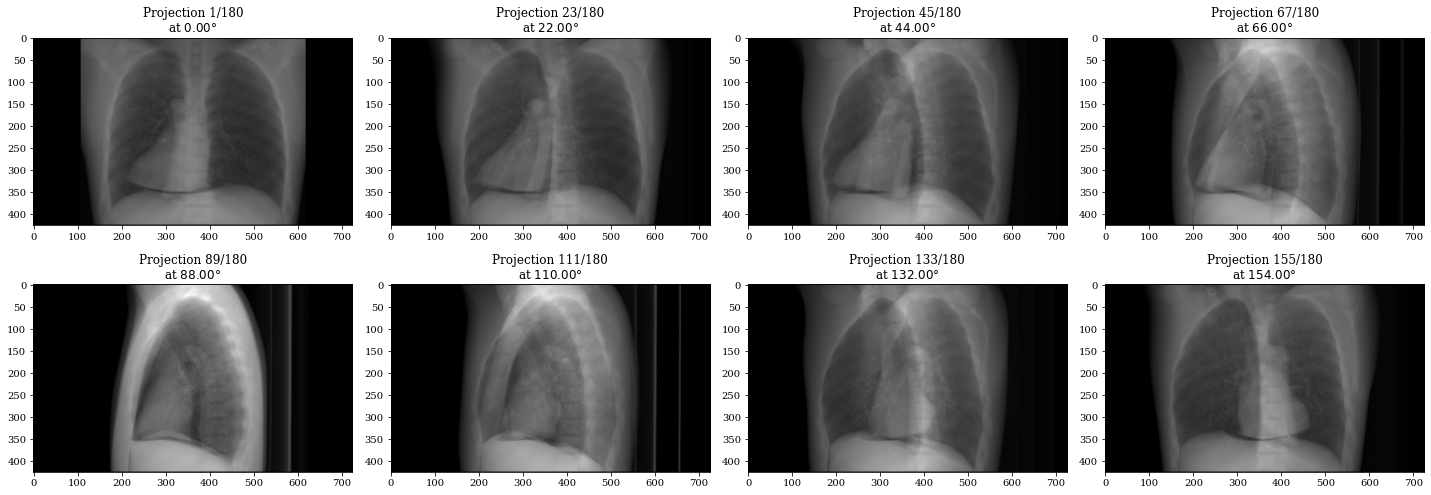

In [26]:
ncols = 4
nrows = 2

step = int(digital_phantom_proj.shape[0] / (ncols * nrows))
slices = range(0, int(digital_phantom_proj.shape[0]), step)

fig = plt.figure(figsize= (20, 7))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Projection " + str(slice_id + 1) + "/" + str(digital_phantom_proj.shape[0]) + "\nat $" + "{:.2f}".format(theta_deg[slice_id]) + "\degree$")
        ax.imshow(skimage.transform.rotate(digital_phantom_proj[slice_id], 180),
                  cmap='gray',
                  vmin=ground_truth_sino_min,
                  vmax=ground_truth_sino_max)

plt.tight_layout()


plt.savefig('plots/lungman-digital_phantom_proj.pdf')
plt.savefig('plots/lungman-digital_phantom_proj.png')

Draw the sinograms

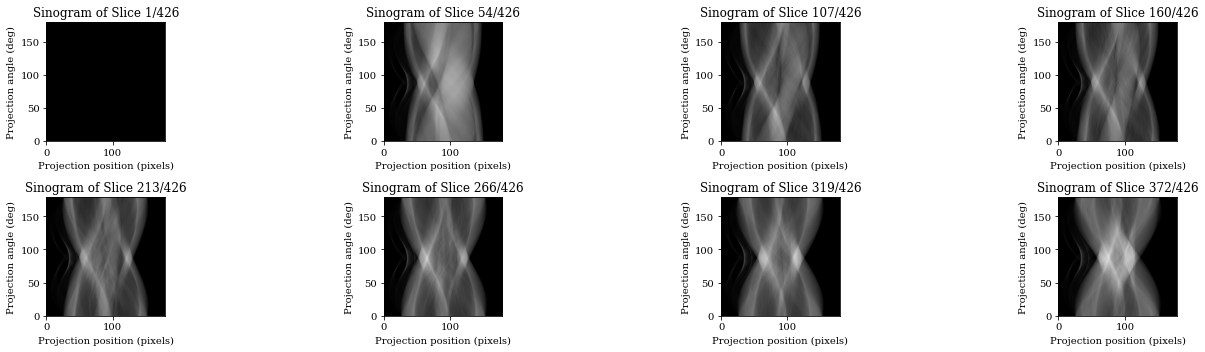

In [27]:
ncols = 4
nrows = 2

step = int(digital_phantom_sino.shape[0] / (ncols * nrows))
slices = range(0, int(digital_phantom_sino.shape[0]), step)

fig = plt.figure(figsize= (20, 5))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Sinogram of Slice " + str(slice_id + 1) + "/" + str(digital_phantom_sino.shape[0]))
        ax.imshow(digital_phantom_sino[slice_id],
                  extent=[0, digital_phantom_sino.shape[1] - 1, theta_deg[0], theta_deg[-1]],
                  cmap='gray',
                  vmin=ground_truth_sino_min, vmax=ground_truth_sino_max)
        ax.set_xlabel("Projection position (pixels)")
        ax.set_ylabel("Projection angle (deg)")
        
 
plt.tight_layout()

plt.savefig('plots/lungman-digital_phantom_sino.pdf')
plt.savefig('plots/lungman-digital_phantom_sino.png')

## CT reconstruction of the ground truth sinogram

In [28]:
fname = "gVirtualXRay_output_data/lungman-digital_phantom_CT_reconst_in_mu.mha"

if ShouldGenerateNew(fname):

    # Scikit-Image
    if tomography_backend == "scikit-image":
        digital_phantom_CT_reconst_in_mu = recons(digital_phantom_sino,
                                              theta_deg,  
                                              "parallel",
                                              "hann",
                                              real_CT_in_HU.shape[2],
                                              real_CT_in_HU.shape[1],
                                              real_CT_in_HU.shape[0],
                                              tomography_backend)
    
    # Tomopy or Tigre
    else:
        digital_phantom_CT_reconst_in_mu = recons(digital_phantom_proj,
                                          theta_deg,  
                                          "parallel", 
                                          "hann", 
                                          real_CT_in_HU.shape[2], 
                                          real_CT_in_HU.shape[1], 
                                          real_CT_in_HU.shape[0], 
                                          tomography_backend)
    
    del digital_phantom_sino # No longer needed
    
    if SAVE_DATA:
        sitk_image = sitk.GetImageFromArray(digital_phantom_CT_reconst_in_mu)
        sitk_image.SetSpacing([pixel_width, pixel_width, pixel_height])

        sitk_image.SetOrigin((-pixel_width * real_CT_in_HU.shape[2] / 2.0,
                              -pixel_width * real_CT_in_HU.shape[1] / 2.0,
                              -pixel_height * real_CT_in_HU.shape[0] / 2.0))

        sitk.WriteImage(sitk_image, fname, useCompression=True)

else:
    sitk_image = sitk.ReadImage(fname)
    digital_phantom_CT_reconst_in_mu = sitk.GetArrayFromImage(sitk_image)

# Transform to Hounsfield units
The hounsfield unit (HU) is frequently used in radiography as a means to standardise radiodensity. On the hounsfield scale, water has a HU of 0 and air -1000. Each pixel in a radiography image corresponds to the photons linear attenuation coefficient or $\mu$. The transformation for each voxel is as follows.


<center>$HU = 1000 \times \frac{\mu - \mu _{water}}{\mu _{water} - \mu _{air}}$</center>

In [29]:
def mu2HU(volume):

#     MU_air = gvxr.getMuFromHU(-1000.0, ray_energy, "keV")
#     MU_water = gvxr.getMuFromHU(0, ray_energy, "keV")

#     print(MU_air, MU_water)
    MU_air = 0
    MU_water = gvxr.getMassAttenuationFromCompound("H2O", ray_energy, "keV")
    # print(MU_air, MU_water)
    
    CT_volume_in_HU = 1000.0 * ((volume - MU_water) / (MU_water - MU_air))
    return np.array(CT_volume_in_HU).astype(np.single)        

In [30]:
fname = "gVirtualXRay_output_data/lungman-digital_phantom_CT_reconst_in_HU.mha"

# The file does not exist
if ShouldGenerateNew(fname):

    digital_phantom_CT_reconst_in_HU = mu2HU(digital_phantom_CT_reconst_in_mu)

    if SAVE_DATA:
        sitk_image = sitk.GetImageFromArray(digital_phantom_CT_reconst_in_HU)
        sitk_image.SetSpacing([pixel_width, pixel_width, pixel_height])

        sitk_image.SetOrigin((-pixel_width * digital_phantom_CT_reconst_in_HU.shape[2] / 2.0,
                              -pixel_width * digital_phantom_CT_reconst_in_HU.shape[1] / 2.0,
                              -pixel_height * digital_phantom_CT_reconst_in_HU.shape[0] / 2.0))

        sitk.WriteImage(sitk_image, fname, useCompression=True)

# The file already exist
else:
    sitk_image = sitk.ReadImage(fname)
    digital_phantom_CT_reconst_in_HU = sitk.GetArrayFromImage(sitk_image)

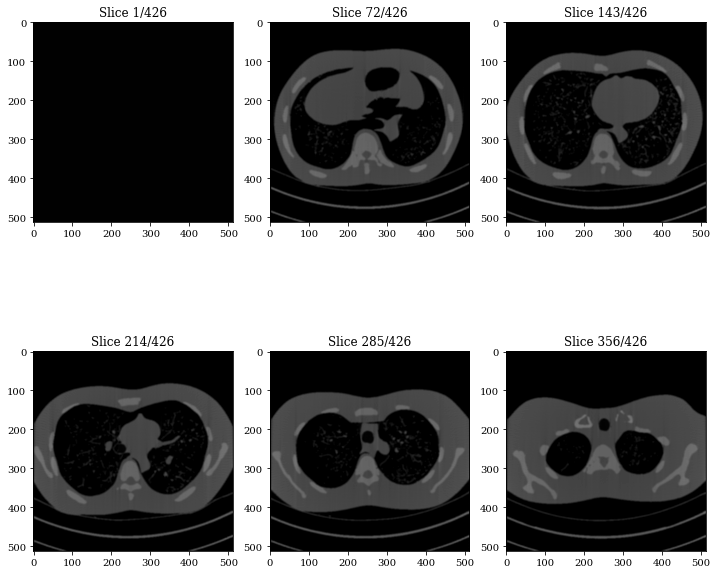

In [31]:
ncols = 3
nrows = 2

step = int(digital_phantom_CT_reconst_in_HU.shape[0] / (ncols * nrows))
slices = range(0, int(digital_phantom_CT_reconst_in_HU.shape[0]), step)

fig = plt.figure(figsize= (10,10))

ct_min_val = real_CT_in_HU.min()
ct_max_val = real_CT_in_HU.max()

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Slice " + str(slice_id + 1) + "/" + str(digital_phantom_CT_reconst_in_HU.shape[0]))
        ax.imshow(digital_phantom_CT_reconst_in_HU[slice_id], cmap='gray', vmin=ct_min_val, vmax=ct_max_val)
        
plt.tight_layout()

plt.savefig('plots/lungman-digital_phantom_CT_reconst_in_HU.pdf')
plt.savefig('plots/lungman-digital_phantom_CT_reconst_in_HU.png')

**Create a phantom model from each mesh and its material.**

In [32]:
json2gvxr.initSamples("notebook-11.json", 1);

Load the 3D data

	Load Bronchioles in lungman_data/meshes/bronchioles.stl using mm
	Load Bronchus in lungman_data/meshes/bronchus.stl using mm
	Load Trachea in lungman_data/meshes/trachea.stl using mm
	Load Diaphram in lungman_data/meshes/diaphram.stl using mm
	Load Skin in lungman_data/meshes/skin.stl using mm
	Load Heart in lungman_data/meshes/heart.stl using mm
	Load Ribs_Spine in lungman_data/meshes/ribs_spine.stl using mm
	Load Scapulas in lungman_data/meshes/scapulas.stl using mm
	Load Sternum in lungman_data/meshes/sternum.stl using mm
	Load Clavicle in lungman_data/meshes/clavicle.stl using mm
	Load Sheets_low in lungman_data/meshes/sheets_low.stl using mm
	Load Sheets_med in lungman_data/meshes/sheets_med.stl using mm
	Load Sheets_high in lungman_data/meshes/sheets_high.stl using mm
	Load -630HU_tumours in lungman_data/meshes/tumours_630HU.stl using mm
	Load 100HU_tumours in lungman_data/meshes/tumours_100HU.stl using mm


In [33]:
number_of_triangles = 0

for sample in json2gvxr.params["Samples"]:
    label = sample["Label"]
    number_of_triangles_in_mesh = gvxr.getNumberOfPrimitives(label)
    number_of_triangles += number_of_triangles_in_mesh
    
print("There are", f"{number_of_triangles:,}", "triangles in total")

There are 19,277,756 triangles in total


## Visualise the virtual patient

In [34]:
if (DO_K3D_PLOT):
    plot = k3d.plot()
    plot.background_color = 0xffffff

    for sample in json2gvxr.params["Samples"]:

        label = sample["Label"]

        fname = sample["Path"]

         #r, g, b, a = gvxr.getAmbientColour(label)
         #R = math.floor(255*r)
         #G = math.floor(255*g)
         #B = math.floor(255*b)
         #A = math.floor(255*a)
        R = sample["Colour"][0];
        G = sample["Colour"][1];
        B = sample["Colour"][2];
        o = sample["Colour"][3];

        k3d_color = 0;
        k3d_color |= (R & 255) << 16;
        k3d_color |= (G & 255) << 8;
        k3d_color |= (B & 255);

        mesh_from_stl_file = mesh.Mesh.from_file(fname)
        opacity = o;
         #if label == "Skin":
         #    opacity = 0.2
         #else:
         #    opacity = 1
        geometry = k3d.mesh(mesh_from_stl_file.vectors.flatten(),
                               range(int(mesh_from_stl_file.vectors.flatten().shape[0] / 3)),
                               color=k3d_color, 
                               wireframe=False, 
                               flat_shading=False,
                               name=fname,
                               opacity=opacity)

        plot += geometry   

    plot.display()
    plot.camera = [458.4242199518181, -394.5268107574361, 59.58430140683608, 93.26420522817403, -15.742963565665017, -45.88423611599179, -0.08892603121323975, 0.11140808541436767, 0.9897880578573034]

Output()

In [52]:
fname = 'plots/lungman_model.png'
if DO_K3D_PLOT and ShouldGenerateNew(fname):

        
    plot.fetch_screenshot() # Not sure why, but we need to do it twice to get the right screenshot
    sleep(5)
    plot.fetch_screenshot();
    data = base64.b64decode(plot.screenshot)
    with open(fname,'wb') as fp:
        fp.write(data)
        fp.flush();
        fp.close();

**Visualise a single projection**

(-0.5, 511.5, 511.5, -0.5)

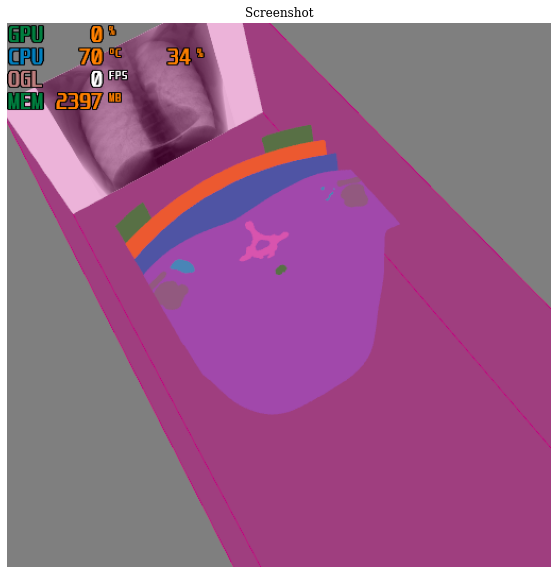

In [36]:
gvxr.computeXRayImage()
gvxr.displayScene()

# Give each mesh an alpha value
alpha = 0.2;
for i in range(gvxr.getNumberOfChildren('root')):
    label = gvxr.getChildLabel('root', i);
    pRGBA = gvxr.getAmbientColour(label);
    gvxr.setColour(label, pRGBA[0], pRGBA[1], pRGBA[2],alpha);

gvxr.useLighing(False)
gvxr.useWireframe(False)
gvxr.setZoom(1000)
gvxr.setSceneRotationMatrix([ 0.8535534,  0.5000000, -0.1464466,0,
  -0.5000000,  0.7071068, -0.5000000,0,
  -0.1464466,  0.5000000,  0.8535534,0,
                            0.0, 0.0, 0.0, 1.0])
gvxr.displayScene()


screenshot = gvxr.takeScreenshot()

plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

# Do projections

Every epoch, the scene is rotated by a step such that the number of chosen projections is reached over 180 degrees and an image is produced on the detector array. At the end a set of X-Ray images is obtained in likeness to the raw data produced by a medical scanner except sliced in a different direction.

In [37]:
%%capture
runtimes = []
fname = "gVirtualXRay_output_data/lungman_flat.mha"
if ShouldGenerateNew(fname):


    gvxr.disableArtefactFiltering()

    if DO_ARTEFACT_FILTERING_ON_GPU:
        gvxr.enableArtefactFilteringOnGPU()
    elif DO_ARTEFACT_FILTERING_ON_CPU:
        gvxr.enableArtefactFilteringOnCPU()

    raw_projections = [];
    angles = [];
    runtimes = []

    # Create a GIF file
    writer = None
    fname_gif = "plots/lungman_acquisition.gif"

    if not os.path.exists(fname_gif):
        writer = imageio.get_writer(fname_gif, mode='I')

    # Save the transformation matrix
    transformation_matrix_backup = gvxr.getSceneTransformationMatrix()

    rotation_axis = json2gvxr.params["Detector"]["UpVector"]

    for angle_id in range(0, number_of_projections):

        # Add the rotation angle, starting from 0
        angles.append(angle_id * angular_step)

        # Compute an X-ray image
        # xray_image = np.array(gvxr.computeXRayImage());
        start_time = datetime.datetime.now()

        xray_image = gvxr.computeXRayImage()

        # if xray_image.shape != [208, 1062]:
        #     xray_image = resize(xray_image, [208, 1062])

        # xray_image = np.array(gvxr.computeXRayImage());

        end_time = datetime.datetime.now()
        delta_time = end_time - start_time
        runtimes.append(delta_time.total_seconds() * 1000)

        # Add to the set of projections
        raw_projections.append(xray_image)

        # Update the rendering
        gvxr.displayScene();

        # Take a screenshot
        if writer is not None:
            if not angle_id % 30:
                screenshot = gvxr.takeScreenshot()

                plt.figure(figsize= (10,10))
                plt.title("Projection " + str(angle_id + 1) + "/" + str(number_of_projections))
                plt.imshow(screenshot)
                plt.axis('off')

                plt.tight_layout()

                plt.savefig('temp.png')            
                plt.close()


                image = imageio.imread("temp.png")
                writer.append_data(image)

        # Rotate the sample
        gvxr.rotateScene(angular_step, rotation_axis[0], rotation_axis[1], rotation_axis[2])

    # We're done with the writer
    if writer is not None:
        writer.close()
        os.remove("temp.png")

    # Convert to numpy arrays
    raw_projections = np.array(raw_projections)

    # Restore the transformation matrix
    gvxr.setSceneTransformationMatrix(transformation_matrix_backup)

    # Update the rendering
    gvxr.displayScene();

In [38]:
if (len(runtimes) > 0):
    runtime_avg = round(np.mean(runtimes))
    runtime_std = round(np.std(runtimes))
else:
    runtime_avg = -1;
    runtime_std = 0;

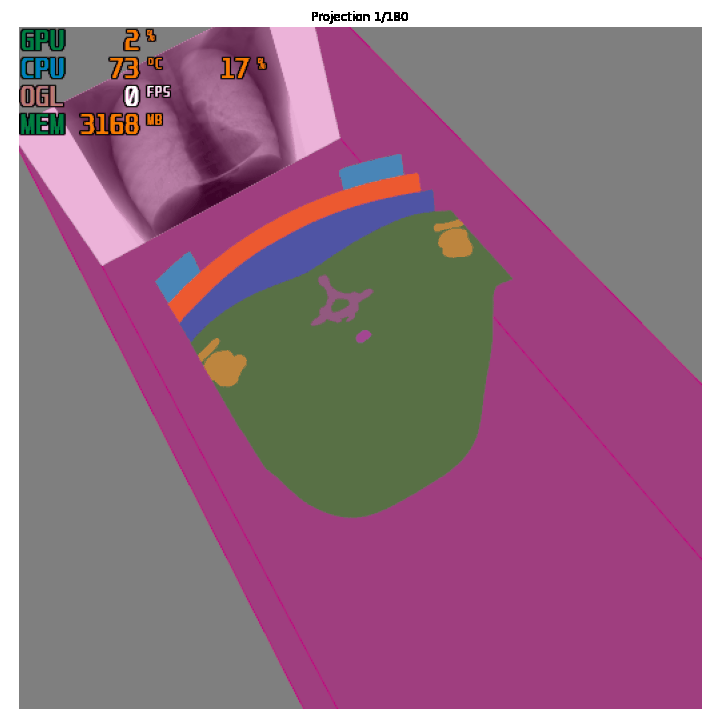

In [39]:
with open('./plots/lungman_acquisition.gif','rb') as f:
    display(Image(data=f.read(), format='png', width=500))

# Correct flat-field

Taking advantage of the detector response when there is no sample can help improve the quality of images when a sample is present. To elaborate, any variance between pixels when the detector is dark (X-Ray beam off) or full (X-Ray beam on) with no density will affect the quality of images with a sample. Factoring for this systematic error is called flat-field correction. \
N: corrected image\
P: projection\
D: dark field\
F: full field\
$N = \frac{P - D}{F - D}$\
In this routine the projection data is flat-fielded.



In [40]:
if ShouldGenerateNew(fname):
    
    corrected_projections = flatFieldCorrection(raw_projections)
    corrected_projections = np.array(corrected_projections).astype(np.single)

    if SAVE_DATA:
        sitk_image = sitk.GetImageFromArray(corrected_projections)
        sitk_image.SetSpacing([pixel_width, pixel_height, angular_step])
        sitk.WriteImage(sitk_image, fname, useCompression=True)
        del raw_projections # Not needed anymore
    
else:
    temp = sitk.ReadImage(fname)
    corrected_projections = sitk.GetArrayFromImage(temp)

# Negative log normalisation

In [41]:
fname = "gVirtualXRay_output_data/lungman_minus_log_projs.mha"

if ShouldGenerateNew(fname):

    minus_log_projs = minusLog(corrected_projections)

    if SAVE_DATA:
        sitk_image = sitk.GetImageFromArray(minus_log_projs)
        sitk_image.SetSpacing([pixel_width, pixel_height, angular_step])
        sitk.WriteImage(sitk_image, fname, useCompression=True)

else:
    temp = sitk.ReadImage(fname)
    minus_log_projs = sitk.GetArrayFromImage(temp)
    
del corrected_projections # Not needed anymore

Display the images

In [42]:
proj_min = minus_log_projs.min()
proj_max = minus_log_projs.max()

Draw the projection

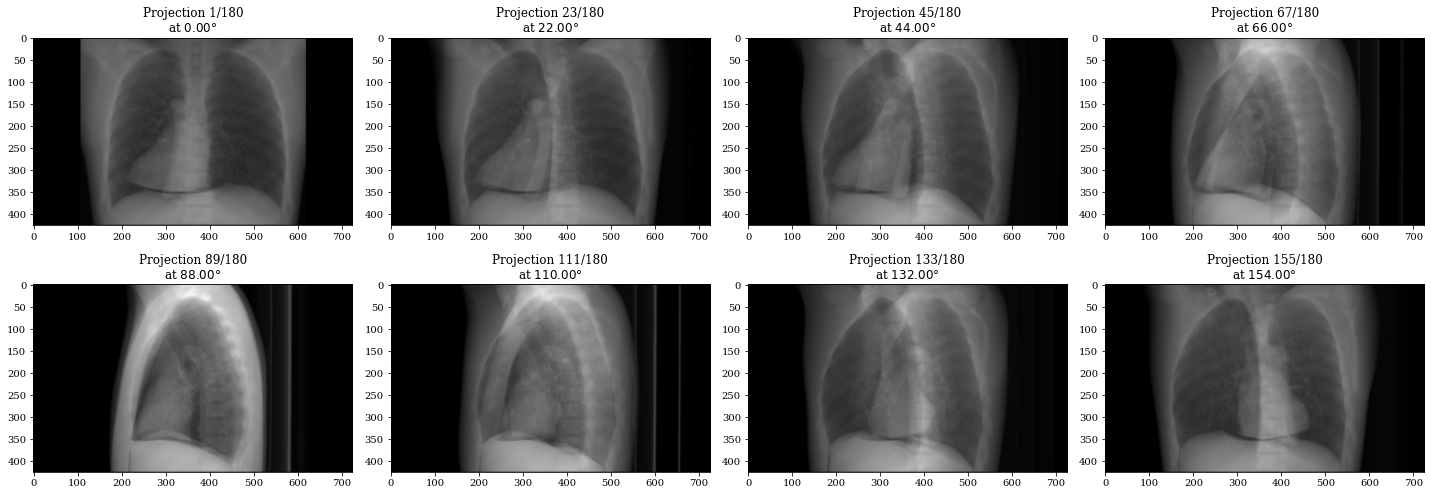

In [43]:
ncols = 4
nrows = 2

step = int(minus_log_projs.shape[0] / (ncols * nrows))
slices = range(0, int(minus_log_projs.shape[0]), step)

fig = plt.figure(figsize= (20, 7))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Projection " + str(slice_id + 1) + "/" + str(minus_log_projs.shape[0]) + "\nat $" + "{:.2f}".format(theta_deg[slice_id]) + "\degree$")
        ax.imshow(skimage.transform.rotate(minus_log_projs[slice_id], 180),
                  cmap='gray',
                  vmin=proj_min,
                  vmax=proj_max)

plt.tight_layout()


plt.savefig('plots/lungmand-simulated-projs.pdf')
plt.savefig('plots/lungmand-simulated-projs.png')

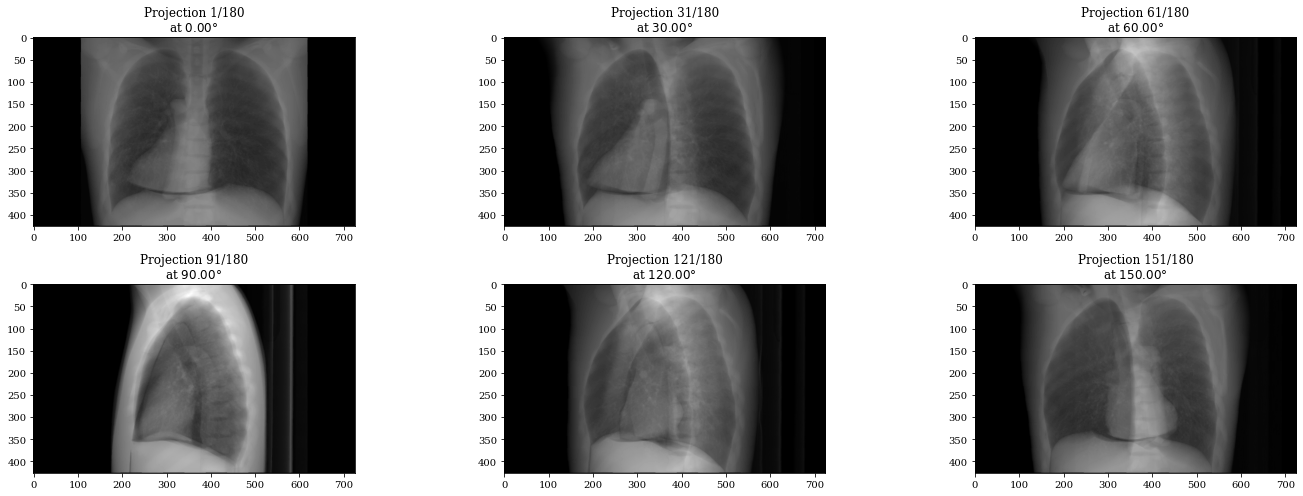

In [44]:
ncols = 3
nrows = 2

step = int(digital_phantom_proj.shape[0] / (ncols * nrows))
slices = range(0, int(digital_phantom_proj.shape[0]), step)

fig = plt.figure(figsize= (20, 7))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Projection " + str(slice_id + 1) + "/" + str(digital_phantom_proj.shape[0]) + "\nat $" + "{:.2f}".format(theta_deg[slice_id]) + "\degree$")
        
        # ref_slice = ground_truth_CT_recons_in_HU[ground_truth_CT_recons_in_HU.shape[0] // 2]
        # test_slice = CT_volume_in_HU[CT_volume_in_HU.shape[0] // 2]

        ref_slice = digital_phantom_proj[slice_id]
        test_slice = minus_log_projs[slice_id]

        comp_equalized = compare_images(ref_slice, test_slice, method='checkerboard', n_tiles=(15,15))

        ax.imshow(skimage.transform.rotate(comp_equalized, 180),
                  cmap='gray',
                  vmin=ground_truth_sino_min,
                  vmax=ground_truth_sino_max)

plt.tight_layout()

plt.savefig('plots/lungman-compare-projs.pdf')
plt.savefig('plots/lungman-compare-projs.png')

Save the sinograms

In [45]:
fname = "gVirtualXRay_output_data/lungman_sinograms.mha"
    
if ShouldGenerateNew(fname):
    
    sino_shape = [
        minus_log_projs.shape[1],
        minus_log_projs.shape[0],
        minus_log_projs.shape[2]
    ]
    
    sinograms = np.zeros(sino_shape).astype(np.single)
    
    for angle_id in range(minus_log_projs.shape[0]):
        for slice_id in range(minus_log_projs.shape[1]):
            sinograms[slice_id, angle_id] = minus_log_projs[angle_id, slice_id]

    # Drop the first and last slices
    # sinograms = sinograms[1:sinograms.shape[0] - 1]
    
    # Save
    if SAVE_DATA:
        sitk_image = sitk.GetImageFromArray(sinograms)
        sitk_image.SetSpacing([pixel_width, angular_step, pixel_height])
        sitk.WriteImage(sitk_image, fname, useCompression=True)

else:
    temp = sitk.ReadImage(fname)
    sinograms = sitk.GetArrayFromImage(temp)

Plot some sinograms

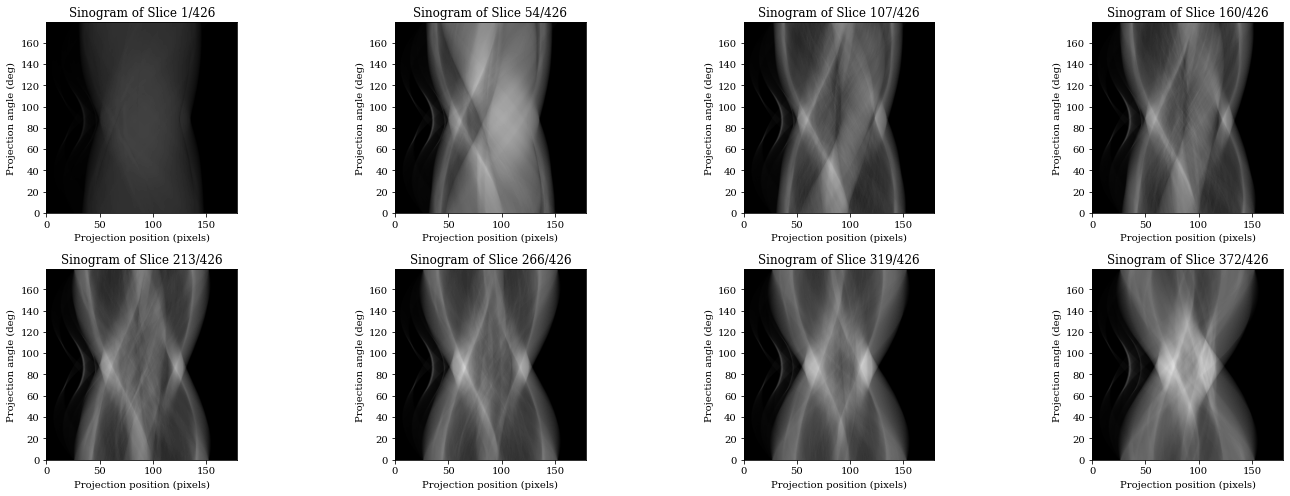

In [46]:
ncols = 4
nrows = 2

step = int(sinograms.shape[0] / (ncols * nrows))
slices = range(0, int(sinograms.shape[0]), step)

fig = plt.figure(figsize= (20, 7))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Sinogram of Slice " + str(slice_id + 1) + "/" + str(sinograms.shape[0]))
        ax.imshow(sinograms[slice_id],
                  extent=[0, sinograms.shape[1] - 1, theta_deg[0], theta_deg[-1]],
                  cmap='gray',
                  vmin=proj_min, vmax=proj_max)
        ax.set_xlabel("Projection position (pixels)")
        ax.set_ylabel("Projection angle (deg)")
        
plt.tight_layout()


plt.savefig('plots/lungman-simulated-sino.pdf')
plt.savefig('plots/lungman-simulated-sino.png')

## Optimise Plastimatch centre
**Use objective function to find optimimum centre. i.e. register the DRR onto the radiograph**

In [47]:
from pymoo.util.misc import stack
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem
from threading import Thread
from sklearn.metrics import mean_absolute_percentage_error

def normImage(image_to_normalise):
    image_to_normalise -= np.mean(image_to_normalise);
    stddev = np.std(image_to_normalise);
    if (stddev == 0): stddev = 0.0001;
    image_to_normalise/= stddev;
    
def measure(truth, predict):
    N = 1.0;
    dims = np.shape(truth);
    for i in range(0, len(dims)):
        N *= dims[i];
    if (N == 0): return -1, -1, -1, -1, -1;
    
    zncc_denom = N * np.std(truth) * np.std(predict);
    if (zncc_denom == 0): zncc_denom = 0.00001;
        
    sub = truth - predict;
    
    mae_score = np.sum(np.abs(sub)) / N;
    zncc_score =  np.sum( (truth  - np.mean(truth)) *(predict - np.mean(predict))) / zncc_denom;
    rmse_score =  np.sqrt(np.sum(np.power(sub, 2)) / N)
    mape_score = mean_absolute_percentage_error(truth, predict);
    ssim_score = ssim(truth, predict);
    return mae_score, zncc_score, rmse_score, mape_score, ssim_score

def objective(cx, cy):
        DRR = doLungmanDRRNumpy(g_NRM[0], g_NRM[1], g_NRM[2], 
                           cx, cy, 
                            "DRR_", 
                            g_XRay.shape[1], g_XRay.shape[0]
                            
                           );
        DRR = DRR.astype(np.single);
        normImage(DRR);
        mae, zncc, rmse, mape, ssim = measure(g_XRay, DRR);
        zncc = 1.0 - ((zncc + 1.0) /2.0);
        ssim = 1.0 - ssim;
        row = []
    
        row.append(mae);
        row.append(zncc);
        row.append(rmse);
        row.append(mape);
        row.append(ssim);
        return row;

class MyProblem(Problem):

    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=5,
                         n_constr=0,
                         xl=np.array([0, -g_XRay.shape[0]]),
                         xu=np.array([g_XRay.shape[1],0])
                         )
    
  
      
    
    def _evaluate(self, X, out, *args, **kwargs):
            objs = []
            for tuple in X:
                objs.append(objective(tuple[0], tuple[1]));

            out["F"] = objs;
        
        
import time
from pymoo.factory import get_termination
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation

termination = get_termination("n_gen", 100)


algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=0.9, eta=15),
    mutation=get_mutation("real_pm", eta=20),
    eliminate_duplicates=False
)
#normImage(xray_AP);
#normImage(xray_RL);

from pymoo.optimize import minimize

**Generate optimise result if not done so already**

In [48]:
import pymoo.core.result;

fname_nsga_rl_X = "gVirtualXRay_output_data/R-L-res-nsga2-X.dat";
fname_nsga_rl_F = "gVirtualXRay_output_data/R-L-res-nsga2-F.dat";
fname_nsga_ap_X = "gVirtualXRay_output_data/A-P-res-nsga2-X.dat";
fname_nsga_ap_F = "gVirtualXRay_output_data/A-P-res-nsga2-F.dat";

r_l_res_exists = ShouldGenerateNew(fname_nsga_rl_X, fname_nsga_rl_F);#False# os.path.exists("gVirtualXRay_output_data/R-L-res-nsga2-X.dat") and \
                # os.path.exists("gVirtualXRay_output_data/R-L-res-nsga2-F.dat");
    
a_p_res_exists = ShouldGenerateNew(fname_nsga_ap_X, fname_nsga_ap_F);#False # os.path.exists("gVirtualXRay_output_data/A-P-res-nsga2-X.dat") and \
                 #os.path.exists("gVirtualXRay_output_data/A-P-res-nsga2-F.dat");

res_ap = pymoo.core.result.Result();
res_rl = pymoo.core.result.Result();

minus_log_proj_rl = np.copy(np.flip(minus_log_projs[(number_of_projections) // 2]));
minus_log_proj_ap = np.copy(np.flip(minus_log_projs[len(minus_log_projs) - 1]));
normImage(minus_log_proj_rl);
normImage(minus_log_proj_ap);
s="Time taken {t} seconds.";

if (r_l_res_exists):
    print("Getting R-L result from file");
    res_rl.X = np.loadtxt(fname_nsga_rl_X)
    res_rl.F = np.loadtxt(fname_nsga_rl_F)
else:
    print("Optimising R-L");
    g_NRM = [1, 0, 0]
    g_XRay = minus_log_proj_rl;
  
    problem = MyProblem();

    t_start = time.time();
    res_rl = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

    t_end = time.time();
    print(s.format(t=(t_end - t_start)));
    
    np.savetxt(fname_nsga_rl_X, res_rl.X)
    np.savetxt(fname_nsga_rl_F, res_rl.F)

if (a_p_res_exists):
    print("Getting A-P result from file");
    res_ap.X = np.loadtxt(fname_nsga_ap_X)
    res_ap.F = np.loadtxt(fname_nsga_ap_F)
else:
    print("Optimising A-P");
    g_NRM = [0, -1, 0]
    g_XRay = minus_log_proj_ap;
    
    problem = MyProblem();

    t_start = time.time();
    res_ap = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

    t_end = time.time();
    print(s.format(t=(t_end - t_start)));
    
    np.savetxt(fname_nsga_ap_X, res_ap.X)
    np.savetxt(fname_nsga_ap_F, res_ap.F)

Optimising R-L


KeyboardInterrupt: 

In [ ]:

print("Optimum c for right to left", f"{res_rl.X[0][0]:.2f}", ",", f"{ res_rl.X[0][1]:.2f}")
DRR_RL = doLungmanDRRNumpy(1, 0, 0, 
                              res_rl.X[0][0], res_rl.X[0][1], 
                                "DRR_RL" 
                               );

print("Optimum c for anterior to posterior", f"{res_ap.X[0][0]:.2f}", ",", f"{ res_ap.X[0][1]:.2f}")
DRR_AP = doLungmanDRRNumpy(0, -1, 0,
                             res_ap.X[0][0], res_ap.X[0][1], 
                                "DRR_AP" 
                               );

normImage(DRR_RL)
normImage(DRR_AP)
displayLinearPowerScales(DRR_RL,  "Simulated lungman projection (Right to left)", "plots/R_L_lungman_radiograph");
displayLinearPowerScales(DRR_AP,  "Simulated lungman projection (Anterior to posterior)", "plots/A_P_lungman_radiograph");

## CT reconstruction of the simulated sinogram

In [ ]:
fname = "gVirtualXRay_output_data/simulated_CT_volume_in_mu.mha"

if True: #not os.path.exists(fname):

    # Scikit-Image
    if tomography_backend == "scikit-image":
        
        filter_name = "ramp" # Default
        filter_name = "shepp-logan"
        filter_name = "cosine"
        filter_name = "hamming"
        filter_name = "hann"     
        
        simulated_CT_volume_in_mu = recons(sinograms,
                                  theta_deg,  
                                  "parallel",
                                  filter_name,
                                  real_CT_in_HU.shape[2],
                                  real_CT_in_HU.shape[1],
                                  real_CT_in_HU.shape[0],
                                  tomography_backend)
    
    # Tomopy or Tigre
    else:
        
        # For TIGRE
        # filter_name = "ram_lak"
        filter_name = "shepp_logan"
        # filter_name = "cosine"
        # filter_name = "hamming"
        # filter_name = "hann"     
        
        
        # For Tomopy
        # filter_name = "shepp"
        # filter_name = "cosine"
        filter_name = "hann"
        # filter_name = "hamming"
        # filter_name = "ramlak"
        # filter_name = "parzen"
        # filter_name = "butterworth"
        
        simulated_CT_volume_in_mu = recons(minus_log_projs,
                                  theta_deg,  
                                  "parallel", 
                                  filter_name,
                                  real_CT_in_HU.shape[2],
                                  real_CT_in_HU.shape[1],
                                  real_CT_in_HU.shape[0],
                                  tomography_backend) 
        
    if SAVE_DATA:
        sitk_image = sitk.GetImageFromArray(simulated_CT_volume_in_mu)
        sitk_image.SetSpacing([pixel_width, pixel_width, pixel_height])

        sitk_image.SetOrigin((-pixel_width * real_CT_in_HU.shape[2] / 2.0,
                              -pixel_width * real_CT_in_HU.shape[1] / 2.0,
                              -pixel_height * real_CT_in_HU.shape[0] / 2.0))

        sitk.WriteImage(sitk_image, fname, useCompression=True)

else:
    sitk_image = sitk.ReadImage(fname)
    simulated_CT_volume_in_mu = sitk.GetArrayFromImage(sitk_image)

# del sinograms # Not needed anymore

# Transform to Hounsfield units

In [ ]:
fname = "gVirtualXRay_output_data/simulated_CT_volume_in_HU.mha"

# The file does not exist
if True: # not os.path.exists(fname):

    simulated_CT_volume_in_HU = mu2HU(simulated_CT_volume_in_mu)

    if SAVE_DATA:
        sitk_image = sitk.GetImageFromArray(simulated_CT_volume_in_HU)
        sitk_image.SetSpacing([pixel_width, pixel_width, pixel_height])

        sitk_image.SetOrigin((-pixel_width * simulated_CT_volume_in_HU.shape[2] / 2.0,
                              -pixel_width * simulated_CT_volume_in_HU.shape[1] / 2.0,
                              -pixel_height * simulated_CT_volume_in_HU.shape[0] / 2.0))

        sitk.WriteImage(sitk_image, fname, useCompression=True)

# The file already exist
else:
    sitk_image = sitk.ReadImage(fname)
    simulated_CT_volume_in_HU = sitk.GetArrayFromImage(sitk_image)

# del CT_volume_in_mu # Not needed anymore

## Comparison the analytic simulation with the ground truth data

### Quantitative validation

Compute image metrics between the two simulated images:

1. [zero-mean normalised cross-correlation (ZNCC)](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)), and
2. [Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity). 


ZNCC can be expressed as a percentage, which eases the interpretation of the numerical values. SSIM is a number between 0 and 1. A good value of ZNCC is 100%, and SSIM 1.

Note than the [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD), is not used due to 1) zero values in the ground truth, and 2)  values are very smalls. Using the MAPE would lead to large errors for these reasons.

In [ ]:
def compare(ref_image, test_image):

    ZNCC = np.mean((ref_image - ref_image.mean()) / ref_image.std() * (test_image - test_image.mean()) / test_image.std())
    print("ZNCC:", "{0:0.2f}".format(100 * ZNCC) + "%")

    offset1 = min(ref_image.min(), test_image.min())
    offset2 = 0.1 * (ref_image.max() - ref_image.min())
    MAPE = mape(ref_image.flatten() - offset1 + offset2, test_image.flatten() - offset1 + offset2)
    print("MAPE:", "{0:0.2f}".format(100 * MAPE) + "%")

    SSIM = ssim(ref_image, test_image, data_range=ref_image.max() - ref_image.min())
    print("SSIM:", "{0:0.2f}".format(SSIM))
    
    return ZNCC, MAPE, SSIM

In [ ]:
real_CT_in_HU = real_CT_in_HU[1:real_CT_in_HU.shape[0] - 1]
digital_phatom_in_HU = digital_phatom_in_HU[1:digital_phatom_in_HU.shape[0] - 1]
digital_phantom_CT_reconst_in_HU = digital_phantom_CT_reconst_in_HU[1:digital_phantom_CT_reconst_in_HU.shape[0] - 1]
simulated_CT_volume_in_HU = simulated_CT_volume_in_HU[1:simulated_CT_volume_in_HU.shape[0] - 1]

real_CT_in_mu = real_CT_in_mu[1:real_CT_in_mu.shape[0] - 1]
digital_phatom_in_mu = digital_phatom_in_mu[1:digital_phatom_in_mu.shape[0] - 1]
digital_phantom_CT_reconst_in_mu = digital_phantom_CT_reconst_in_mu[1:digital_phantom_CT_reconst_in_mu.shape[0] - 1]
simulated_CT_volume_in_mu = simulated_CT_volume_in_mu[1:simulated_CT_volume_in_mu.shape[0] - 1]

## real CT vs digital phantom HU

In [ ]:
compare(real_CT_in_HU, digital_phatom_in_HU);

In [ ]:
ref_slice = real_CT_in_HU[real_CT_in_HU.shape[0] // 2]
test_slice = digital_phatom_in_HU[digital_phatom_in_HU.shape[0] // 2]

fullCompareImages(ref_slice,
                  test_slice,
                  "Digital phantom",
                  "plots/lungman-compare-real_CT_in_HU-digital_phatom_in_HU",
                  False,
                  -1000, 1000)

## real CT vs digital phantom mu

In [ ]:
compare(real_CT_in_mu, digital_phatom_in_mu);

In [ ]:
ref_slice = real_CT_in_mu[real_CT_in_HU.shape[0] // 2]
test_slice = digital_phatom_in_mu[digital_phatom_in_HU.shape[0] // 2]

fullCompareImages(ref_slice,
                  test_slice,
                  "Digital phantom",
                  "plots/lungman-compare-real_CT_in_mu-digital_phatom_in_mu",
                  False,
                  0, 0.3)

## real CT vs recons of digital phantom HU

In [ ]:
compare(real_CT_in_HU, digital_phantom_CT_reconst_in_HU);

In [ ]:
ref_slice = real_CT_in_HU[real_CT_in_HU.shape[0] // 2]
test_slice = digital_phantom_CT_reconst_in_HU[digital_phantom_CT_reconst_in_HU.shape[0] // 2]

fullCompareImages(ref_slice,
                  test_slice,
                  "Reconstructed from\nDigital phantom projections",
                  "plots/lungman-compare-real_CT_in_HU-digital_phantom_CT_reconst_in_HU",
                  False,
                  -1000, 1000)

## real CT vs recons of digital phantom mu

In [ ]:
compare(digital_phatom_in_mu, digital_phantom_CT_reconst_in_mu);

In [ ]:
ref_slice = real_CT_in_mu[real_CT_in_mu.shape[0] // 2]
test_slice = digital_phantom_CT_reconst_in_mu[digital_phantom_CT_reconst_in_HU.shape[0] // 2]

fullCompareImages(ref_slice,
                  test_slice,
                  "Reconstructed from\nDigital phantom projections",
                  "plots/lungman-compare-real_CT_in_mu-digital_phantom_CT_reconst_in_mu",
                  False,
                  0, 0.3)

## Real CT vs recons of simu projs HU

In [ ]:
ZNCC_CT, MAPE_CT, SSIM_CT = compare(real_CT_in_HU, simulated_CT_volume_in_HU);

In [ ]:
ref_slice = real_CT_in_HU[real_CT_in_HU.shape[0] // 2]
test_slice = simulated_CT_volume_in_HU[simulated_CT_volume_in_HU.shape[0] // 2]

fullCompareImages(ref_slice,
                  test_slice,
                  "gVirtualXRay",
                  "plots/lungman-compare-real_CT_in_HU-simulated_CT_volume_in_HU",
                  False,
                  -1000, 1000)

## Real CT vs recons of simu projs mu

In [ ]:
compare(real_CT_in_mu, simulated_CT_volume_in_mu);

In [ ]:
ref_slice = real_CT_in_mu[real_CT_in_HU.shape[0] // 2]
test_slice = simulated_CT_volume_in_mu[simulated_CT_volume_in_HU.shape[0] // 2]

fullCompareImages(ref_slice,
                  test_slice,
                  "gVirtualXRay",
                  "plots/lungman-compare-real_CT_in_mu-simulated_CT_volume_in_mu",
                  False,
                  0, 0.3)

## digital phantom  vs recons of simu projs HU

In [ ]:
compare(digital_phatom_in_HU, simulated_CT_volume_in_HU);

In [ ]:
ref_slice = digital_phatom_in_HU[digital_phatom_in_HU.shape[0] // 2]
test_slice = simulated_CT_volume_in_HU[simulated_CT_volume_in_HU.shape[0] // 2]

fullCompareImages(ref_slice,
                  test_slice,
                  "gVirtualXRay",
                  "plots/lungman-compare-digital_phatom_in_HU-simulated_CT_volume_in_HU",
                  False,
                  -1000, 1000)

## digital phantom vs recons of simu projs mu

In [ ]:
compare(digital_phatom_in_mu, simulated_CT_volume_in_mu);

In [ ]:
ref_slice = digital_phatom_in_mu[digital_phatom_in_mu.shape[0] // 2]
test_slice = simulated_CT_volume_in_mu[simulated_CT_volume_in_mu.shape[0] // 2]

fullCompareImages(ref_slice,
                  test_slice,
                  "gVirtualXRay",
                  "plots/lungman-compare-digital_phatom_in_mu-simulated_CT_volume_in_mu",
                  False,
                  0, 0.3)

## recons of digital phantom vs recons of simu projs HU

In [ ]:
ZNCC_phantom, MAPE_phantom, SSIM_phantom = compare(digital_phantom_CT_reconst_in_HU, simulated_CT_volume_in_HU);

In [ ]:
ref_slice = digital_phantom_CT_reconst_in_HU[digital_phantom_CT_reconst_in_HU.shape[0] // 2]
test_slice = simulated_CT_volume_in_HU[simulated_CT_volume_in_HU.shape[0] // 2]

fullCompareImages(ref_slice,
                  test_slice,
                  "gVirtualXRay",
                  "plots/lungman-compare-digital_phantom_CT_reconst_in_HU-simulated_CT_volume_in_HU",
                  False,
                  -1000, 1000)

## recons of digital phantom  vs recons of simu projs mu

In [ ]:
compare(digital_phantom_CT_reconst_in_mu, simulated_CT_volume_in_mu);

In [ ]:
ref_slice = digital_phantom_CT_reconst_in_mu[digital_phantom_CT_reconst_in_mu.shape[0] // 2]
test_slice = simulated_CT_volume_in_mu[simulated_CT_volume_in_mu.shape[0] // 2]

fullCompareImages(ref_slice,
                  test_slice,
                  "gVirtualXRay",
                  "plots/lungman-compare-digital_phantom_CT_reconst_in_mu-simulated_CT_volume_in_mu",
                  False,
                  0, 0.3)

In [ ]:
real_CT_diag = np.diag(real_CT_in_HU[real_CT_in_HU.shape[0] // 2])
digital_phatom_diag = np.diag(digital_phatom_in_HU[digital_phatom_in_HU.shape[0] // 2])
digital_phantom_CT_reconst_diag = np.diag(digital_phantom_CT_reconst_in_HU[digital_phantom_CT_reconst_in_HU.shape[0] // 2])
lungman_simu_CT_recons_diag = np.diag(simulated_CT_volume_in_HU[simulated_CT_volume_in_HU.shape[0] // 2])

plt.figure(figsize=(15, 5))

ax = plt.subplot(111)

ax.set_title("Diagonal profiles")

ax.plot(real_CT_diag, label="Experimental CT")
ax.plot(digital_phatom_diag, label="Digital phantom from segmentation")
ax.plot(digital_phantom_CT_reconst_diag, label="CT reconstructed from projections\nof digital phantom")
ax.plot(lungman_simu_CT_recons_diag, label="CT reconstructed from projections\nsimulated using gVirtualXRay")

ax.legend(loc='best',
          ncol=2, fancybox=True, shadow=True)

# plt.legend()

plt.savefig('plots/lungman-profiles-CT-HU.pdf')
plt.savefig('plots/lungman-profiles-CT-HU.png')

In [ ]:
real_CT_diag = np.diag(real_CT_in_mu[real_CT_in_mu.shape[0] // 2])
digital_phatom_diag = np.diag(digital_phatom_in_mu[digital_phatom_in_mu.shape[0] // 2])
digital_phantom_CT_reconst_diag = np.diag(digital_phantom_CT_reconst_in_mu[digital_phantom_CT_reconst_in_mu.shape[0] // 2])
lungman_simu_CT_recons_diag = np.diag(simulated_CT_volume_in_mu[simulated_CT_volume_in_mu.shape[0] // 2])

plt.figure(figsize=(15, 5))

ax = plt.subplot(111)

ax.set_title("Diagonal profiles")

ax.plot(real_CT_diag, label="Experimental CT")
ax.plot(digital_phatom_diag, label="Digital phantom from segmentation")
ax.plot(digital_phantom_CT_reconst_diag, label="CT reconstructed from projections\nof digital phantom")
ax.plot(lungman_simu_CT_recons_diag, label="CT reconstructed from projections\nsimulated using gVirtualXRay")

ax.legend(loc='best',
          ncol=2, fancybox=True, shadow=True)

# plt.legend()

plt.savefig('plots/lungman-profiles-CT-mu.pdf')
plt.savefig('plots/lungman-profiles-CT-mu.png')

## Projections

In [ ]:
ZNCC_projs, MAPE_projs, SSIM_projs = compare(digital_phantom_proj, minus_log_projs)

In [ ]:
ref_slice = digital_phantom_proj[digital_phantom_proj.shape[0] // 2]
test_slice = minus_log_projs[minus_log_projs.shape[0] // 2]

ref_slice = skimage.transform.rotate(ref_slice, 180)
test_slice = skimage.transform.rotate(test_slice, 180)

fullCompareImages(ref_slice,
                  test_slice,
                  "gVirtualXRay",
                  "plots/lungman-compare-projs",
                  False,
                  ref_slice.min(), ref_slice.max())

In [ ]:
print('R-L:')
ref_proj = DRR_RL
test_proj = minus_log_proj_rl
ZNCC_projs, MAPE_projs, SSIM_projs = compare(ref_proj, test_proj)
fullCompareImages(ref_proj,
                  test_proj,
                  "gVirtualXRay",
                  "plots/lungman-compare-projs-plastimatch-rl",
                  False,
                  ref_slice.min(), ref_slice.max())
print('\nA-P:')

ref_proj = DRR_AP
test_proj = minus_log_proj_ap
ZNCC_projs, MAPE_projs, SSIM_projs = compare(ref_proj, test_proj)
fullCompareImages(ref_proj,
                  test_proj,
                  "gVirtualXRay",
                  "plots/lungman-compare-projs-plastimatch-ap",
                  False,
                  ref_slice.min(), ref_slice.max())

In [ ]:
ref_diag = np.diag(ref_slice)
test_diag = np.diag(test_slice)

plt.figure(figsize=(15, 5))

ax = plt.subplot(111)

ax.set_title("Diagonal profiles")

ax.plot(ref_diag, label="DRR from phantom")
ax.plot(test_diag, label="Projection simulated using gVirtualXRay")

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

plt.legend()

Print a row of the table for the paper

In [ ]:
print("Lungman CT acquisition & Projection of synthetic volume & " + 
      "{0:0.2f}".format(100 * MAPE_projs) + "\\%    &    " +
      "{0:0.2f}".format(100 * ZNCC_projs) + "\\%    &    " +
      "{0:0.2f}".format(SSIM_projs) + "    &    $" +
      str(digital_phantom_proj.shape[2]) + " \\times " + str(digital_phantom_proj.shape[1]) + " \\times " + str(digital_phantom_proj.shape[0]) + "$    &    " +
      str(number_of_triangles) + "    &    " +
      "$" + str(runtime_avg) + " \\pm " + str(runtime_std) + "$ \\\\")

In [ ]:
print("Lungman CT reconstruction & Reconstruction of synthetic volume & " + 
      "{0:0.2f}".format(100 * MAPE_phantom) + "\\%    &    " +
      "{0:0.2f}".format(100 * ZNCC_phantom) + "\\%    &    " +
      "{0:0.2f}".format(SSIM_phantom) + "    &    $" +
      str(digital_phantom_CT_reconst_in_mu.shape[2]) + " \\times " + str(digital_phantom_CT_reconst_in_mu.shape[1]) + " \\times " + str(digital_phantom_CT_reconst_in_mu.shape[0]) + "$    &    " +
      str(number_of_triangles) + "    &    " +
      "$" + str(runtime_avg) + " \\pm " + str(runtime_std) + "$ \\\\")

In [ ]:
print("Lungman CT reconstruction & Real CT & " + 
      "{0:0.2f}".format(100 * MAPE_CT) + "\\%    &    " +
      "{0:0.2f}".format(100 * ZNCC_CT) + "\\%    &    " +
      "{0:0.2f}".format(SSIM_CT) + "    &    $" +
      str(digital_phantom_CT_reconst_in_mu.shape[2]) + " \\times " + str(digital_phantom_CT_reconst_in_mu.shape[1]) + " \\times " + str(digital_phantom_CT_reconst_in_mu.shape[0]) + "$    &    " +
      str(number_of_triangles) + "    &    " +
      "$" + str(runtime_avg) + " \\pm " + str(runtime_std) + "$ \\\\")

In [ ]:
ncols = 3
nrows = 2

ref_volume = real_CT_in_HU # digital_phantom_CT_reconst_in_mu
test_volume = simulated_CT_volume_in_HU


step = int(ref_volume.shape[0] / (ncols * nrows))
slices = range(0, int(ref_volume.shape[0]), step)

fig = plt.figure(figsize= (10,10))


for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Slice " + str(slice_id + 1 + 1) + "/" + str(ref_volume.shape[0] + 2))
        
        # ref_slice = ground_truth_CT_recons_in_HU[ground_truth_CT_recons_in_HU.shape[0] // 2]
        # test_slice = CT_volume_in_HU[CT_volume_in_HU.shape[0] // 2]

        ref_slice = ref_volume[slice_id]
        test_slice = test_volume[slice_id]

        comp_equalized = compare_images(ref_slice, test_slice, method='checkerboard', n_tiles=(15,15))

        ax.imshow(comp_equalized, cmap='gray', vmin=-1000, vmax=1000)
        
plt.tight_layout()

plt.savefig('plots/lungman-compare-real-simulated-CT-HU.pdf')
plt.savefig('plots/lungman-compare-real-simulated-CT-HU.png')

In [ ]:
ncols = 3
nrows = 2

ref_volume = digital_phantom_CT_reconst_in_HU
test_volume = simulated_CT_volume_in_HU


step = int(ref_volume.shape[0] / (ncols * nrows))
slices = range(0, int(ref_volume.shape[0]), step)

fig = plt.figure(figsize= (10,10))


for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Slice " + str(slice_id + 1 + 1) + "/" + str(ref_volume.shape[0] + 2))
        
        # ref_slice = ground_truth_CT_recons_in_HU[ground_truth_CT_recons_in_HU.shape[0] // 2]
        # test_slice = CT_volume_in_HU[CT_volume_in_HU.shape[0] // 2]

        ref_slice = ref_volume[slice_id]
        test_slice = test_volume[slice_id]

        comp_equalized = compare_images(ref_slice, test_slice, method='checkerboard', n_tiles=(15,15))

        ax.imshow(comp_equalized, cmap='gray', vmin=-1000, vmax=1000)
        
plt.tight_layout()

plt.savefig('plots/lungman-compare-phantom-simulated-CT-HU.pdf')
plt.savefig('plots/lungman-compare-phantom-simulated-CT-HU.png')

## Check Hounsfield Units for all the structures

In [ ]:
# Read the map for isovalue/label to average HU
sitk_meta_reader = sitk.ImageFileReader();
sitk_meta_reader.SetImageIO("MetaImageIO");
mapHandle = open("./lungman_data/segmentation-uncompressed/map.dat");
bytes = mapHandle.read();
split_lines = bytes.split('\n');
bytes = None;
mapHandle.close();

# Read the labbeled volume
label_rel_path = "./lungman_data/segmentation-uncompressed/labels.mha" ;#+ tuple_parts[2];
sitk_meta_reader.SetFileName(label_rel_path);
labels = sitk_meta_reader.Execute();

# Create the binary erosion filter
erode = sitk.BinaryErodeImageFilter();

offset1 = min(real_CT_in_HU.min(), simulated_CT_volume_in_HU.min())
offset2 = 0.01 * (real_CT_in_HU.max() - real_CT_in_HU.min())
ground_truth_CT_recons_in_HU_corrected = real_CT_in_HU - offset1 + offset2
CT_volume_in_HU_corrected = simulated_CT_volume_in_HU - offset1 + offset2


acc_avg_rel_diff = 0;
vec_avg_rel_diff = [];
i = 0;
cols=["Name","Mean reference HU","Stddev reference HU", "Mean simulated HU", "Stddev simulated HU", "Relative Error (in %)", "Absolute Error"]
data = []
print("Name\t\tReference HU\tSimulated HU\tRelative Error (in %)\tAbsolute Error");
while ( i < len(split_lines)):
    row = []
    tuple_parts = split_lines[i].split('\t');
    
    name = tuple_parts[2][0:-4];
    kernel_radius = 2;
    
    # Sheets are too slim to be eroded so much
    if (name.find("sheet") != -1):
        kernel_radius = 1;
    
    # Erode the mask
    erode.SetKernelRadius(kernel_radius);
    erode.SetForegroundValue(int(tuple_parts[0]));
    sitk_mask = erode.Execute(labels);
        
    mask = np.array(sitk.GetArrayFromImage(sitk_mask));
    sitk_mask = None
   
    # Drop the first and last slices
    mask = mask[1:mask.shape[0] - 1]

    # Apply mask to simulated CT
    simulated_masked = simulated_CT_volume_in_HU[mask == int(tuple_parts[0])];#ma.masked_where(mask > 0, Simulated_CT_in_HU)
    ground_masked = real_CT_in_HU[mask == int(tuple_parts[0])];#ma.masked_where(mask > 0, Simulated_CT_in_HU)
    
    # abs_diff = np.mean(np.abs(simulated_masked - ground_masked))
    # avg_rel_diff = np.mean(np.abs((simulated_masked - ground_masked) / ground_masked)) * 100
    
    avg_simulated_HU = np.mean(simulated_masked);
    stddev_simulated_HU = np.std(simulated_masked);
    # avg_ground_HU = float(tuple_parts[1]);
    avg_ground_HU = np.mean(ground_masked);
    stddev_ground_HU = np.std(ground_masked);
    
    avg_rel_diff = (avg_ground_HU - avg_simulated_HU) / avg_ground_HU;
    avg_rel_diff *= 100.0;
    abs_diff =  abs(avg_simulated_HU - avg_ground_HU);

#     ground_corrected_masked = ground_truth_CT_recons_in_HU_corrected[mask == int(tuple_parts[0])];#ma.masked_where(mask > 0, Simulated_CT_in_HU)
#     simulated_corrected_masked = CT_volume_in_HU_corrected[mask == int(tuple_parts[0])];#ma.masked_where(mask > 0, Simulated_CT_in_HU)

#     diff = ground_corrected_masked - simulated_corrected_masked
#     abs_diff = np.mean(np.abs(diff))
#     avg_rel_diff = 100 * np.mean(np.abs(diff / ground_corrected_masked))


    format = "{structure:<15}\t{ref:<15.3f}\t{sim:<15.3f}\t{rel:<15.3f}\t\t{abs:.3f}";
    print(format.format(structure=name, ref=avg_ground_HU, sim=avg_simulated_HU, rel=avg_rel_diff, abs=abs_diff));
    row.append(name)
    row.append(avg_ground_HU)
    row.append(stddev_ground_HU)
    row.append(avg_simulated_HU)
    row.append(stddev_simulated_HU)
    row.append(avg_rel_diff)
    row.append(abs_diff)
    
    data.append(row)
    
    acc_avg_rel_diff += abs(avg_rel_diff);
    vec_avg_rel_diff.append(acc_avg_rel_diff);
    i+=1;
    
avg_rel_diff = acc_avg_rel_diff / len(vec_avg_rel_diff);
print('\n')
format = "Average relative error = {error:.3f}%";
print(format.format(error=avg_rel_diff));

In [ ]:
df_HU = pd.DataFrame(data=data, columns=cols)
df_HU.to_csv("gVirtualXRay_output_data/lungman-HU.csv")